# Практикум по анализу данных.

### Ссылка на датасет: https://www.kaggle.com/datasets/beaver68/cars-dataset-in-russia

### Данные представляют собой набор из 50+ характеристик автомобиля. Информация представленна более чем для 22 000 автомобилей из России на конец 2020 года.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
%load_ext rpy2.ipython

In [298]:
%%R
library(glue)

In [631]:
df = pd.read_csv('cars_dataset.csv', index_col = 0)

# Предобработка признаков

# предобработка Wheel_size

In [411]:
df.loc[24:34, ["Wheel_size"]]

Wheel_size
24              235/65/R17
25              235/65/R17
26              235/65/R17
27  235/60/R18  255/50/R19
28  235/60/R18  255/50/R19
29  275/50/R20  255/50/R19
30              255/50/R19
31  275/50/R20  255/50/R19
32  235/60/R18  255/50/R19
33  275/50/R20  255/50/R19
34              255/50/R19

In [412]:
df.Wheel_size.fillna("0/0/R0", inplace=True)
def split_sizes(wheel_size):
    return wheel_size.strip().split("  ")
df['Wheel_size'] = df['Wheel_size'].apply(split_sizes)
df = df.explode('Wheel_size')

### Признак Wheel_size содержит в себе ширину шины (мм), высоту профиля (%) и диаметр обода (inch). Разделим этот признак на три, новые признаки назовём tire_width, aspect_ratio, wheel_diametr.

In [413]:
df["Wheel_size"] = df["Wheel_size"].str.split("/R|/")

In [414]:
def get_tire_width(wheel_size):
    return int(wheel_size[0])
def get_aspect_ratio(wheel_size):
    return int(wheel_size[1])
def get_wheel_diametr(wheel_size):
    return int(wheel_size[2])

df["Tire_width"] = df.Wheel_size.apply(get_tire_width)
df["Aspect_ratio"] = df.Wheel_size.apply(get_aspect_ratio)
df["Wheel_diametr"] = df.Wheel_size.apply(get_wheel_diametr)

In [415]:
df.loc[24:34, ["Wheel_size", "Tire_width", "Aspect_ratio", "Wheel_diametr"]]

Wheel_size  Tire_width  Aspect_ratio  Wheel_diametr
24  [235, 65, 17]         235            65             17
25  [235, 65, 17]         235            65             17
26  [235, 65, 17]         235            65             17
27  [235, 60, 18]         235            60             18
27  [255, 50, 19]         255            50             19
28  [235, 60, 18]         235            60             18
28  [255, 50, 19]         255            50             19
29  [275, 50, 20]         275            50             20
29  [255, 50, 19]         255            50             19
30  [255, 50, 19]         255            50             19
31  [275, 50, 20]         275            50             20
31  [255, 50, 19]         255            50             19
32  [235, 60, 18]         235            60             18
32  [255, 50, 19]         255            50             19
33  [275, 50, 20]         275            50             20
33  [255, 50, 19]         255            50             19
34  [255, 50, 19]         255            50             19

In [416]:
df.drop("Wheel_size", axis=1, inplace=True)

### предобработка year 

In [632]:
df.set_index(pd.Index(range(0, df.shape[0])), inplace=True)#в оригинальном датафрейме некоторые индексы пропущены
df['Year'] = df['Year'].astype('int64')
df[df.dtypes[df.dtypes == 'float64'].index] = df[df.dtypes[df.dtypes == 'float64'].index].astype('float64')
df['mark'] = df.mark.str.strip()

In [421]:
%%R -i df
df$Volume <- as.double(df$Volume)

# 1. Аппроксимация распределений данных с помощью ядерных оценок.

### Построим ядерные оценки плотности для:  
+ **объёма двигателя**    
+ **года выпуска**  
+ **пробега**  
+ **максимальной мощности**  
+ **длины и ширины автомобиля**

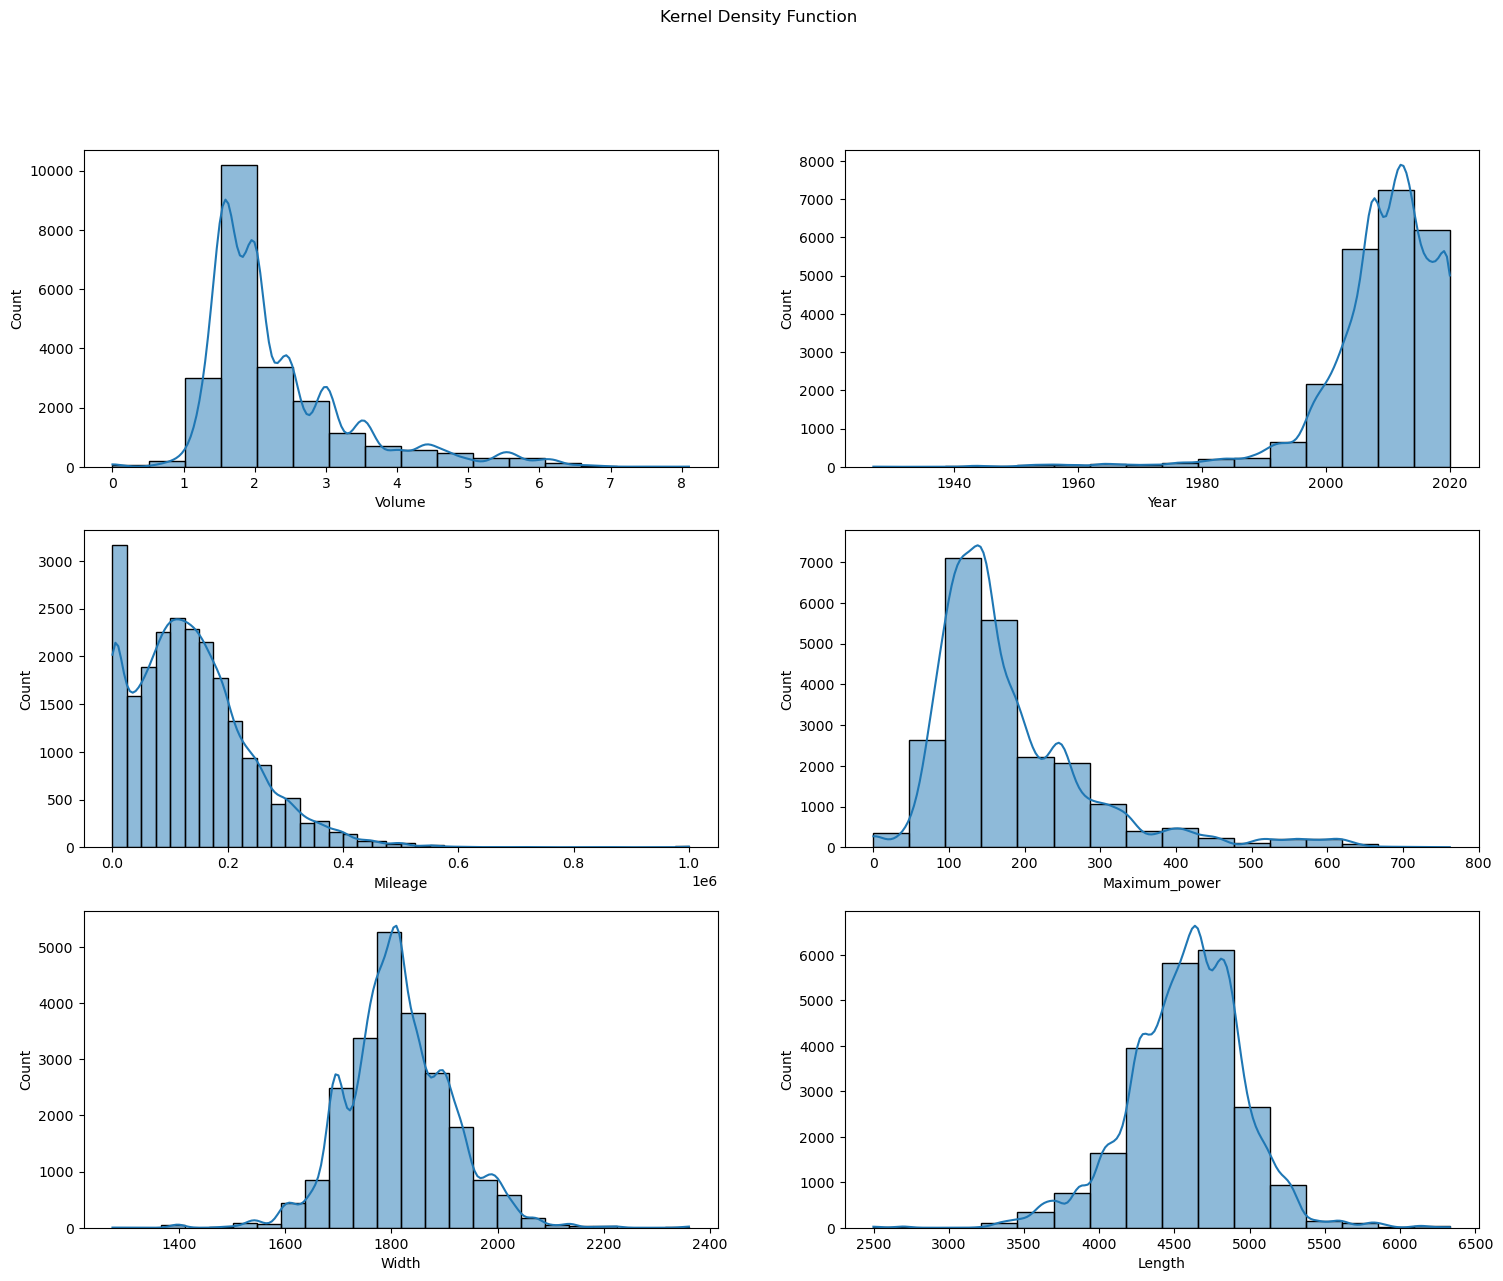

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

fig.suptitle('Kernel Density Function')

sns.histplot(ax=axes[0, 0], data = df, x='Volume', kde=True, bins = 16, common_norm=False)
sns.histplot(ax=axes[0, 1], data = df, x='Year', kde=True, bins = 16, common_norm=False)
sns.histplot(ax=axes[1, 0], data = df, x='Mileage', kde=True, bins = 40, common_norm=False)
sns.histplot(ax=axes[1, 1], data = df, x='Maximum_power', kde=True, bins = 16, common_norm=False)
sns.histplot(ax=axes[2, 0], data = df, x='Width', kde=True, bins = 24, common_norm=False)
sns.histplot(ax=axes[2, 1], data = df, x='Length', kde=True, bins = 16, common_norm=False);

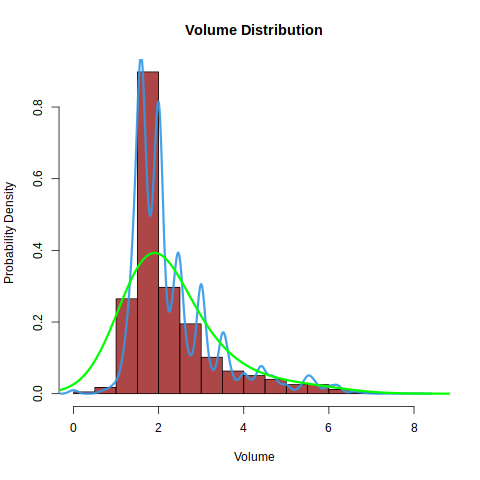

In [7]:
%%R
hist(df$Volume, breaks = 16, freq = FALSE, col = rgb(0.6, 0.1, 0.1, 0.8),
     xlab = "Volume",
     ylab = "Probability Density",
     main = "Volume Distribution")
lines(density(df$Volume), col = rgb(0.2, 0.6, 0.9, 0.9), lwd = 3)
lines(density(df$Volume, bw=0.7), col = "green", lwd = 3)

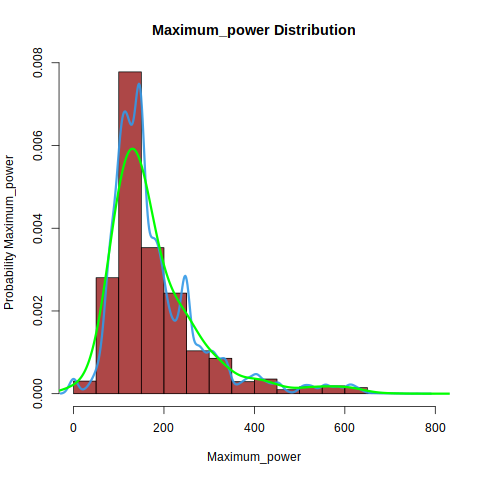

In [8]:
%%R
hist(df$Maximum_power, breaks = 12, freq = FALSE, col = rgb(0.6, 0.1, 0.1, 0.8),
     xlab = "Maximum_power",
     ylab = "Probability Maximum_power",
     main = "Maximum_power Distribution")
lines(density(df$Maximum_power), col = rgb(0.2, 0.6, 0.9, 0.9), lwd = 3)
lines(density(df$Maximum_power, bw=30.), col = "green", lwd = 3)

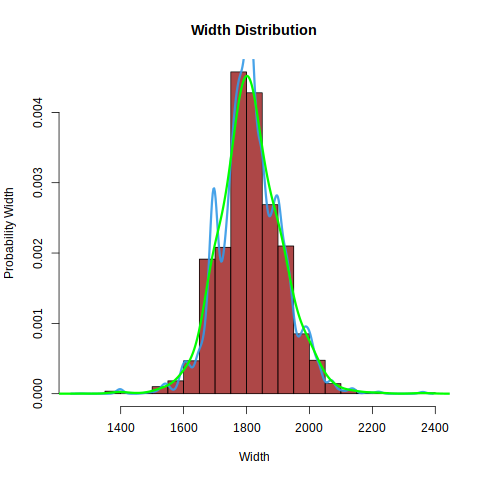

In [9]:
%%R
hist(df$Width, breaks = 16, freq = FALSE, col = rgb(0.6, 0.1, 0.1, 0.8),
     xlab = "Width",
     ylab = "Probability Width",
     main = "Width Distribution")
lines(density(df$Width), col = rgb(0.2, 0.6, 0.9, 0.9), lwd = 3)
lines(density(df$Width, bw=30.), col = "green", lwd = 3)

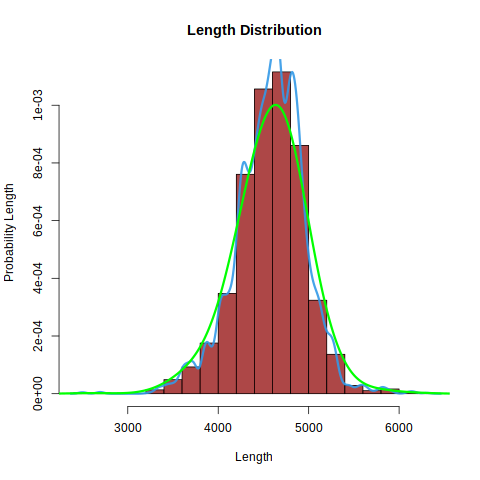

In [10]:
%%R
hist(df$Length, breaks = 24, freq = FALSE, col = rgb(0.6, 0.1, 0.1, 0.8),
     xlab = "Length",
     ylab = "Probability Length",
     main = "Length Distribution")
lines(density(df$Length), col = rgb(0.2, 0.6, 0.9, 0.9), lwd = 3)
lines(density(df$Length, bw=200.), col = "green", lwd = 3)

# 2. Анализ данных с помощью cdplot, dotchart, boxplot и stripchart.

### Построим график зависимости цены от пробега для автомобилей марки BMW

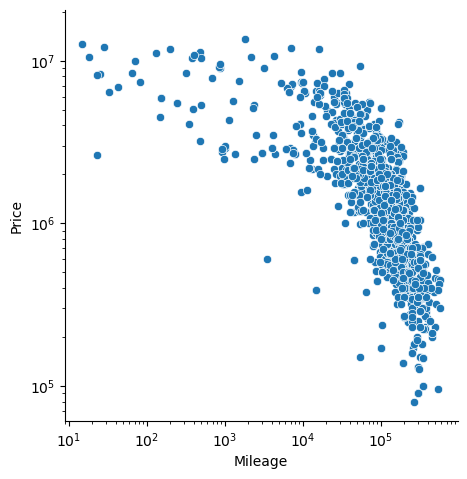

In [11]:
sns.relplot(x='Mileage',\
            y='Price',\
            data=df[df.mark == "BMW"])
plt.xscale('log')
plt.yscale('log')

### Видно, что цена на автомобили с меньшем пробегом выше.  
### Посмотрим как ведёт себя эта зависимость на разных типах коробки передач

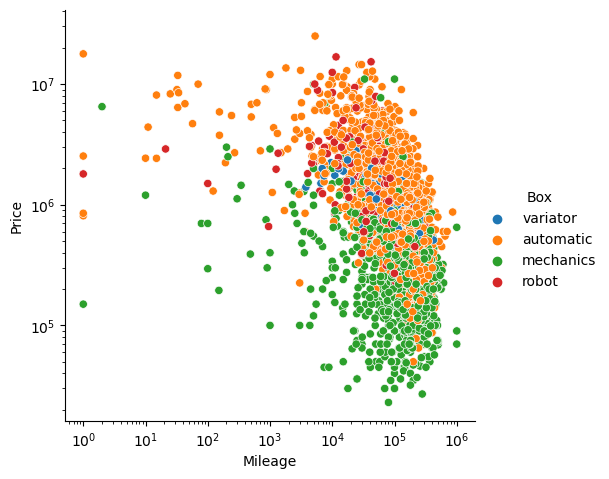

In [12]:
sns.relplot(x = 'Mileage',\
            y = 'Price',\
            data = df.sample(5000),
            hue = "Box")
plt.xscale('log')
plt.yscale('log')

### Заметим, что в среднем цена на автомобили с механической коробкой передач ниже чем на автомобили с автоматической коробкой.  Построим boxplot и убедимся в этом.

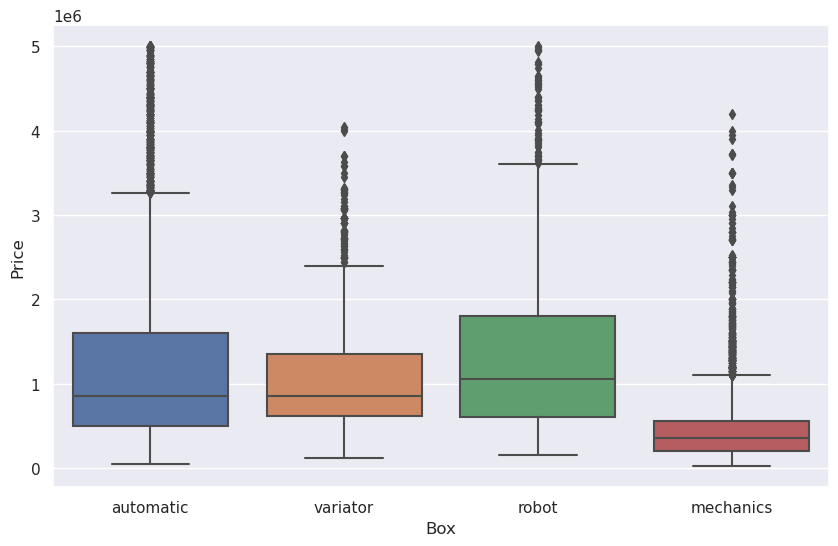

In [13]:
sns.set (rc={"figure.figsize":( 10 , 6 )})
sns.boxplot(x='Box', y='Price', data=df[df.Price < 5 * 10**6]);
#взяли только автомобили с ценой ниже 5 млн руб, чтобы получить качественный график

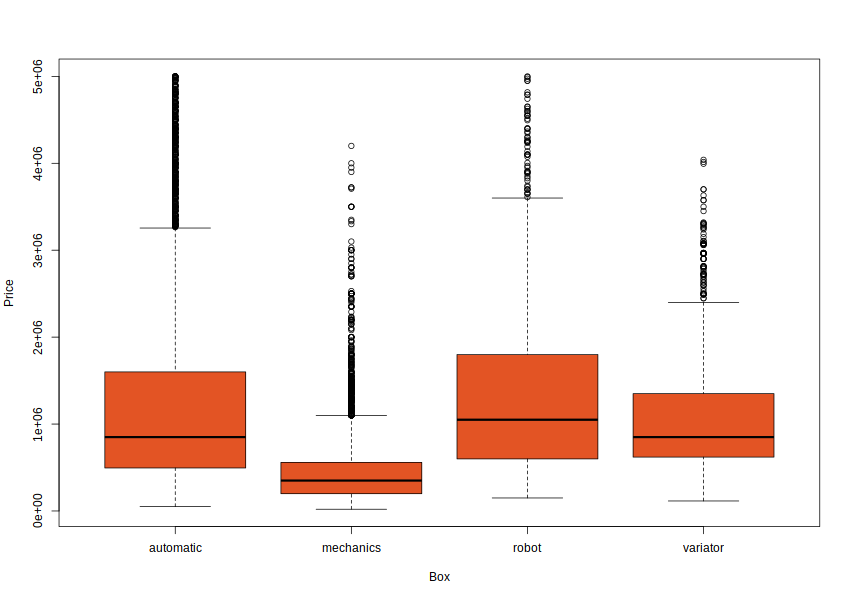

In [14]:
%%R -w 850 -h 600
data = subset(df, Price < 5 * 10**6, select = c('Box', "Price"))
boxplot(Price ~ Box, col = rgb(0.89, 0.33, 0.14, 1),  data = data)

### Пожалуй тремя самыми дорогими и попурными марками автомобилей в России считаются Mercedes, BMW и Audi. Возьмём 10 самых попурных марок автомобилей и построим boxplot цены. 

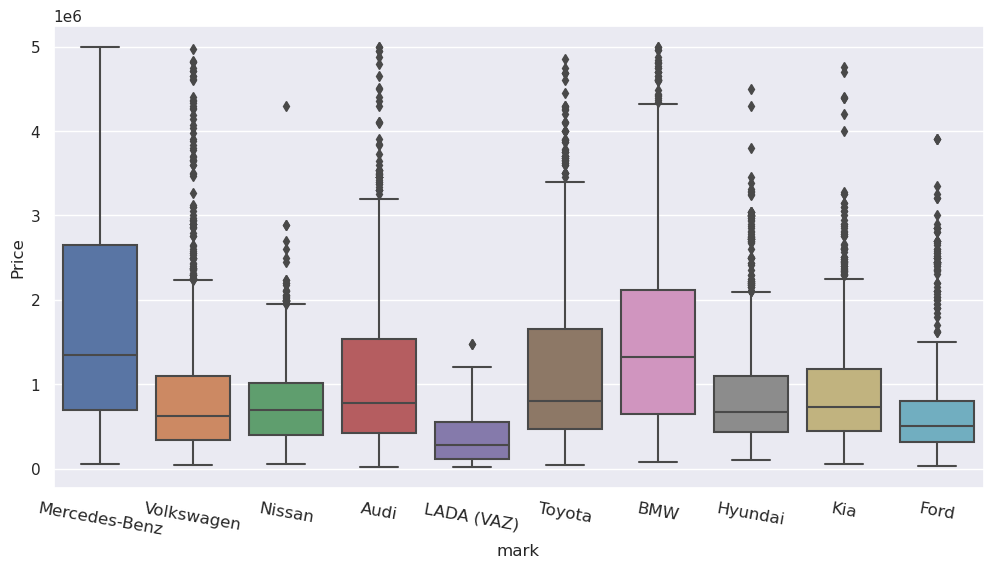

In [15]:
top_10_popular_marks = df.mark.value_counts().sort_values(ascending=False)[:10].index
mark_prices = df[df.mark.isin(top_10_popular_marks) & (df.Price < 5 * 10**6)]
sns.set (rc={"figure.figsize":( 12 , 6 )})
sns.boxplot(x='mark', y='Price', data=mark_prices)
plt.tick_params(axis='x', which='major', labelsize=12, rotation=-10)

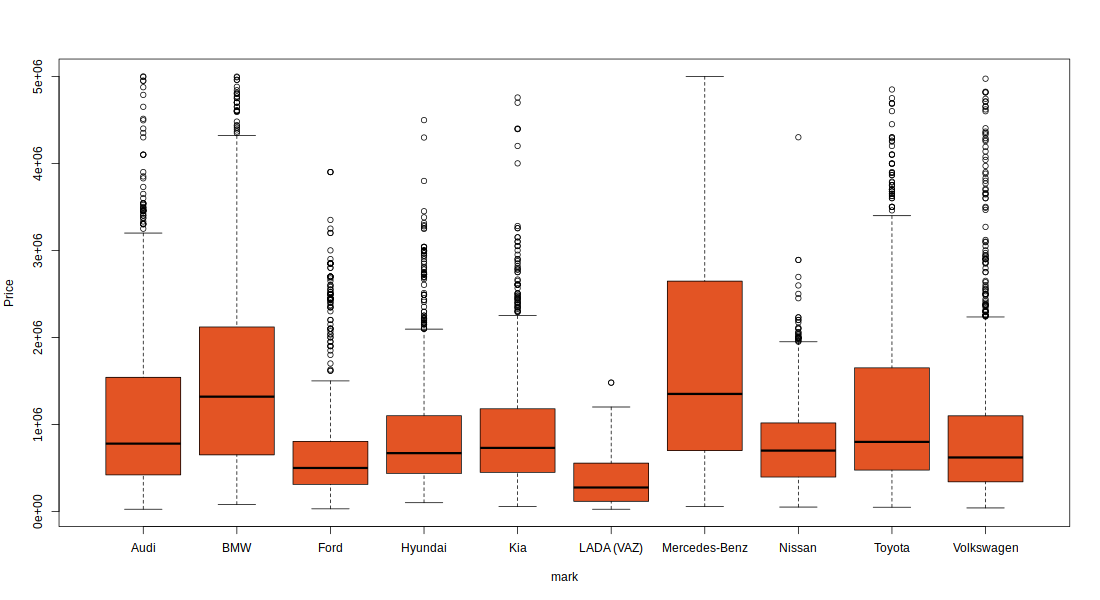

In [16]:
%%R -i mark_prices -w 1100 -h 600
library(repr)
boxplot(Price ~ mark, col = rgb(0.89, 0.33, 0.14, 1),  data = mark_prices)

### Также построим boxplot цены для 10 самых популярных стран производителей.

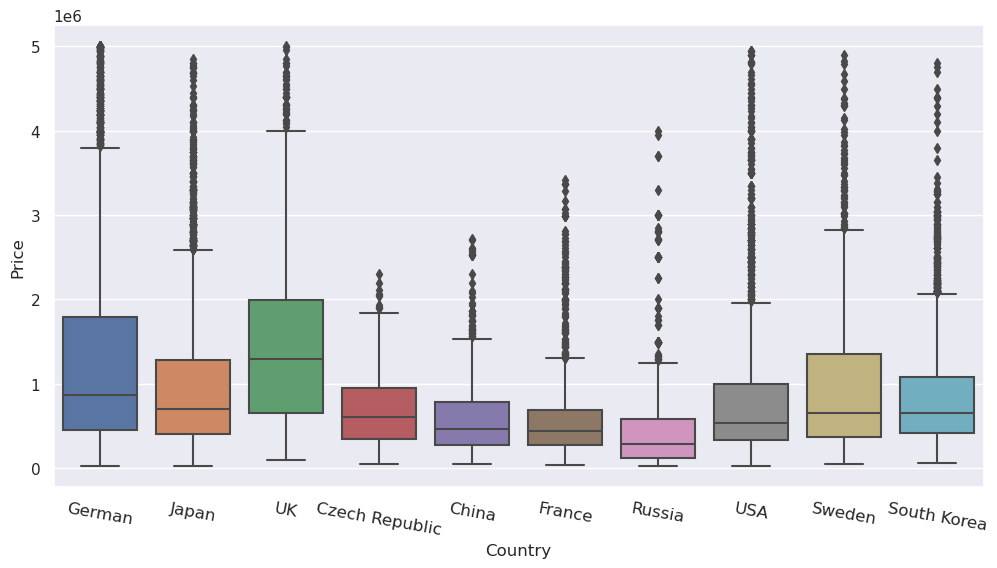

In [17]:
top_10_popular_countries = df.Country.value_counts().sort_values(ascending=False)[:10].index
country_prices = df[df.Country.isin(top_10_popular_countries) & (df.Price < 5 * 10**6)]
sns.set (rc={"figure.figsize":( 12 , 6 )})
sns.boxplot(x='Country', y='Price', data=country_prices)
plt.tick_params(axis='x', which='major', labelsize=12, rotation=-10)

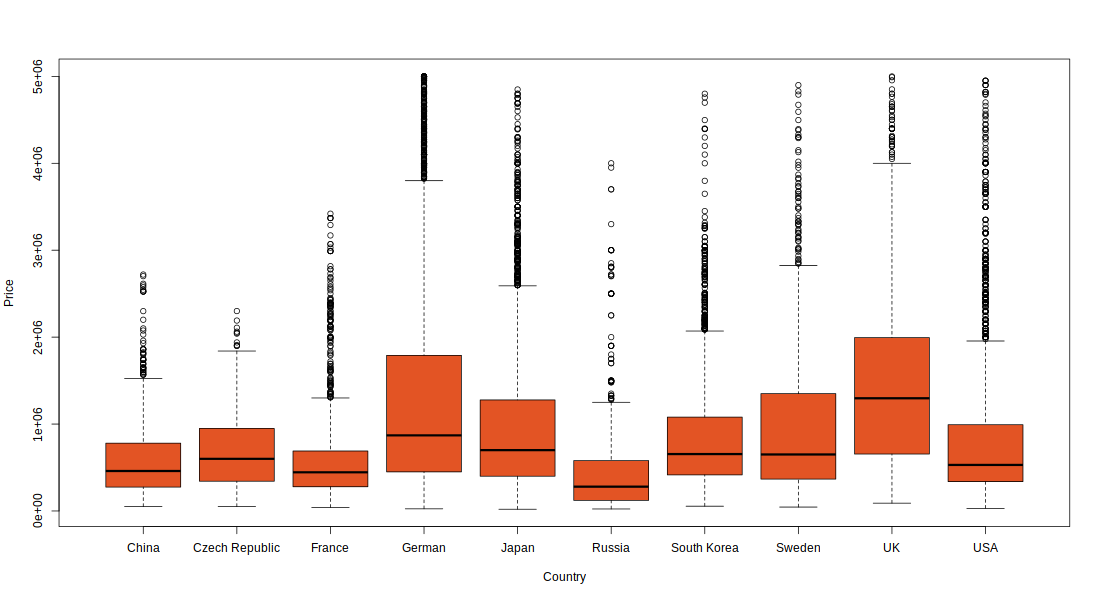

In [18]:
%%R -i country_prices -w 1100 -h 600
library(repr)
boxplot(Price ~ Country, col = rgb(0.89, 0.33, 0.14, 1),  data = country_prices)

### Очевидно, что на рынке больше ценнятся новые автомобли. Можем заметить, что зависимость цены от года выпуска экспоненциальная.

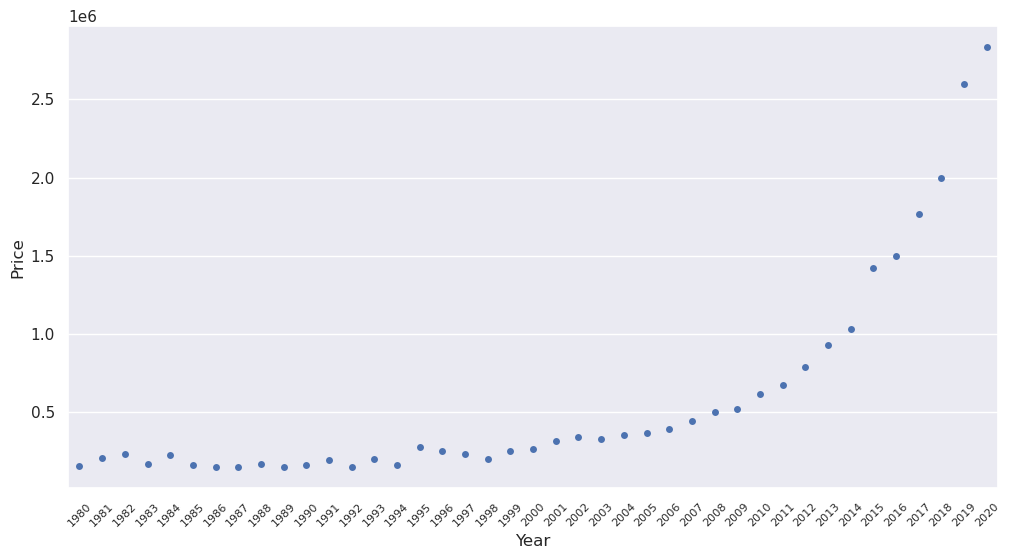

In [19]:
med_price_per_year = df.loc[df.Year >=1980, ['Year', 'Price']].groupby('Year', as_index=False).median()
sns.stripplot(x='Year', y='Price', data=med_price_per_year)
plt.tick_params(axis='x', which='major', labelsize=8, rotation=45)

plt.show()

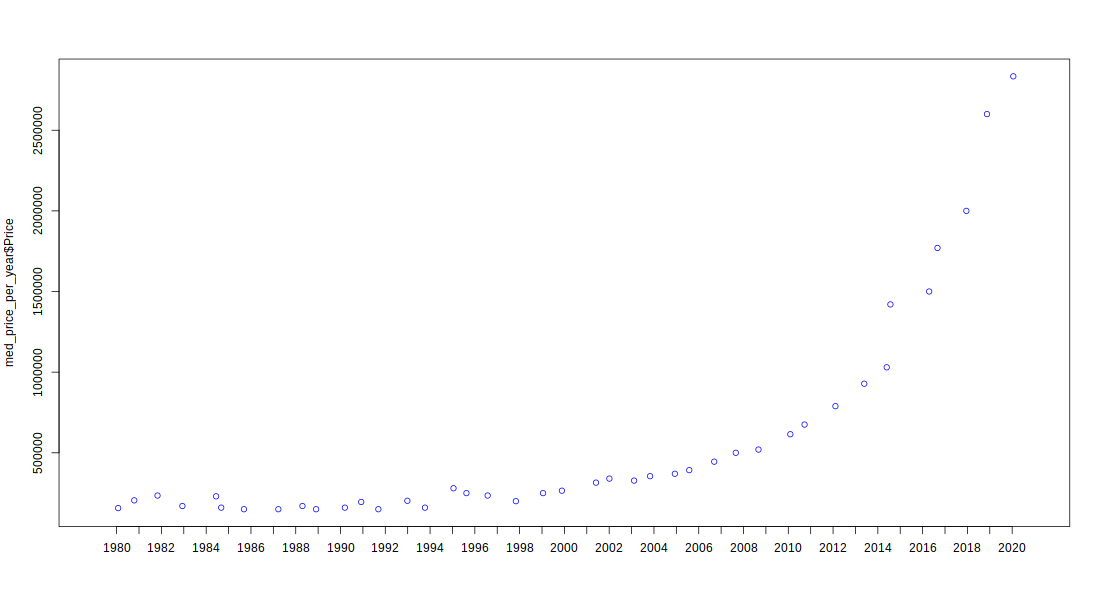

In [20]:
%%R -i med_price_per_year -w 1100 -h 600
stripchart(med_price_per_year$Price ~ med_price_per_year$Year,
           method = "jitter",
           jitter = 0.45,
           pch = 1, col = 'blue', vertical = TRUE)

### Мощность автомобиля увеличивается при увеличении количества цилиндров двигалеля 

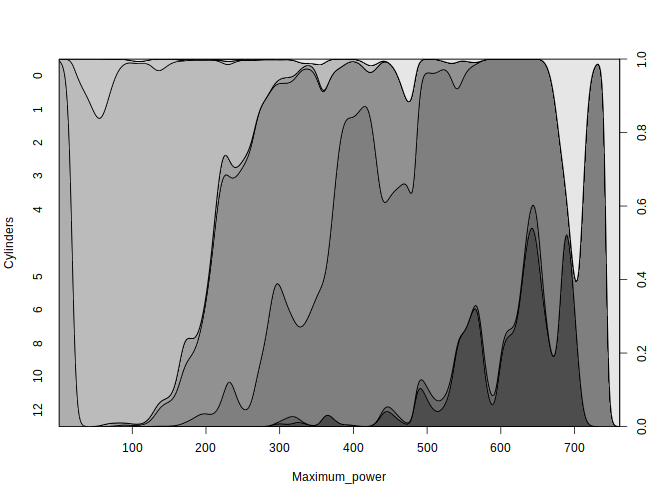

In [21]:
%%R -w 650 -h 500
df$Cylinders <- as.factor(df$Cylinders)
cdplot(Cylinders ~ Maximum_power, data=df)

### Кроме того у более тяжёлых машин (класс которых выше) мощность тоже должна быть больше. Что мы и наблюдаем ниже.

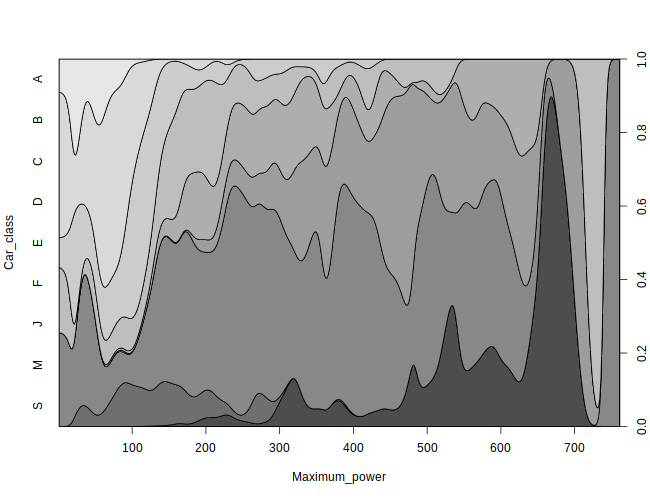

In [22]:
%%R -w 650 -h 500
df$Car_class <- as.factor(df$Car_class)
cdplot(Car_class ~ Maximum_power, data=df)

### Убедимся в этом ещё раз построив график медианной максимальной мощности от типа класса

In [23]:
med_mp_per_class = df.groupby("Car_class", as_index = False)['Maximum_power'].median().rename(\
            columns={"Maximum_power" : "Median_Maximum_power"}).sort_values("Median_Maximum_power")

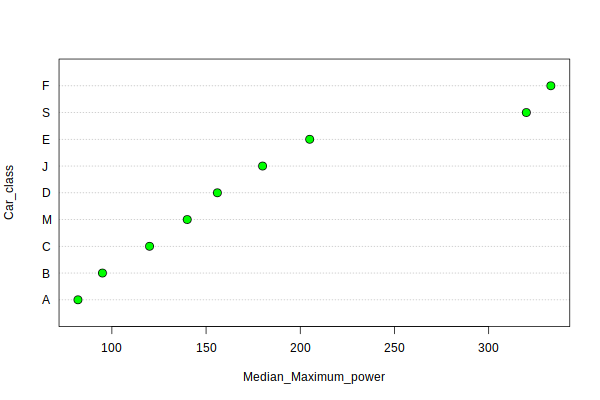

In [24]:
%%R -i med_mp_per_class -w 600 -h 400
dotchart(med_mp_per_class$Median_Maximum_power, labels = unique(med_mp_per_class$Car_class),
         pch = 21, bg = "green", pt.cex = 1.5, xlab = "Median_Maximum_power", ylab = "Car_class")

## 3. Проверка, являются ли наблюдения выбросами с точки зрения формальных статистических критериев Граббса и Q-теста Диксона. Визуализация результатов.

### Проведём тест Граббса на данных о цене автомобиля

In [25]:
from outliers import smirnov_grubbs as grubbs

len(grubbs.max_test_indices(np.array(df.Price), alpha=0.01))

728

### При уровне значимости в 1 процент тест выдаёт 728 выбросов. Посмотрим на некоторые из них.

In [26]:
df.loc[list(grubbs.max_test_indices(np.array(df.Price), alpha=0.01)),\
       ['Price', 'mark', 'Model', 'Year', 'Mileage']].sort_values("Price", ascending=False).head(10)

Price           mark       Model  Year  Mileage
17713  130000000.0        Maybach         62   2009   1724.0
17883  130000000.0        Maybach         62   2009   1724.0
11379   57000000.0    Rolls-Royce    Phantom   2020    500.0
22374   52500000.0  Mercedes-Benz       W188   1952  12000.0
11378   51200000.0    Rolls-Royce    Phantom   2020      0.0
20798   33215000.0        Ferrari  GTC4Lusso   2020      0.0
2074    31800000.0    Rolls-Royce     Wraith   2020      0.0
20800   29531000.0        Ferrari  GTC4Lusso   2020      0.0
2077    29400000.0    Rolls-Royce     Wraith   2020      0.0
2075    29000000.0    Rolls-Royce     Wraith   2020      0.0

In [27]:
%%R
library(outliers)
grubbs.test(df$Price)


	Grubbs test for one outlier

data:  df$Price
G = 51.58498, U = 0.88277, p-value < 2.2e-16
alternative hypothesis: highest value 1.3e+08 is an outlier



In addition: Warning message:
package ‘outliers’ was built under R version 4.2.3 


In [28]:
%%R
subset(df[, c('Price', 'mark', 'Model', 'Year')], df$Price == 1.3*10**8)

        Price    mark Model Year
17713 1.3e+08 Maybach   62  2009
17883 1.3e+08 Maybach   62  2009


### Видим,  что с точки зрения цены тест считает выбросами Maybach, Rolls-Royce и Ferrari.

### Проведём тот же тест для максимальной скорости

In [29]:
grubbs.max_test_indices(np.array(df.Maximum_speed), alpha=.05),\
grubbs.max_test_indices(np.array(df.Maximum_speed), alpha=.1)

([], [19688, 19689])

In [30]:
df.loc[list(grubbs.max_test_indices(np.array(df.Maximum_speed), alpha=.1)),\
       ['Maximum_speed', 'mark', 'Model', 'Year']]

Maximum_speed     mark  Model  Year
19688          341.0  McLaren  720S   2018
19689          341.0  McLaren  720S   2017

In [31]:
%%R
grubbs.test(df$Maximum_speed)


	Grubbs test for one outlier

data:  df$Maximum_speed
G = 4.5230, U = 0.9991, p-value = 0.0689
alternative hypothesis: highest value 341 is an outlier



In [32]:
%%R
subset(df[, c('Maximum_speed', 'mark', 'Model', 'Year')], df$Maximum_speed == 341)

      Maximum_speed    mark Model Year
19688           341 McLaren 720S  2018
19689           341 McLaren 720S  2017


### Видим, что McLaren является выбросом.

### Проведём тест Граббса для максимальной мощности автомобилей

In [33]:
np.array(grubbs.max_test_indices(np.array(df.Maximum_power), alpha=.05)).reshape(1, -1)

array([[18108, 19688, 19689, 19672, 19788, 19793, 19813, 20798, 20799,
        20800,  9496, 21487, 21488, 21489, 21490,  6523,  6524, 13317,
        13318]])

In [34]:
df.loc[list(grubbs.max_test_indices(np.array(df.Maximum_power), alpha=.05)),\
      ['Maximum_power', 'mark', 'Model', 'Year']].sort_values('Maximum_power', ascending=False).head(10)

Maximum_power     mark        Model  Year
18108          762.0    Tesla     Model X   2016
19689          720.0  McLaren        720S   2017
19688          720.0  McLaren        720S   2018
19672          717.0    Dodge  Challenger   2020
19788          700.0    Tesla     Model S   2015
19793          700.0    Tesla     Model S   2015
19813          700.0    Tesla     Model S   2015
20799          690.0  Ferrari   GTC4Lusso   2016
20800          690.0  Ferrari   GTC4Lusso   2020
20798          690.0  Ferrari   GTC4Lusso   2020

In [35]:
%%R
grubbs.test(df$Maximum_power)


	Grubbs test for one outlier

data:  df$Maximum_power
G = 5.60700, U = 0.99862, p-value = 0.0002311
alternative hypothesis: highest value 762 is an outlier



In [36]:
%%R
subset(df[, c('Maximum_power', 'mark', 'Model', 'Year')], Maximum_power == 762)

      Maximum_power  mark    Model Year
18108           762 Tesla Model X  2016


### Тест посчитал Tesla Model X 2016 года с 762 л.с. выбросом, что справедливо. Также выбросом считается McLaren 720 S

## Q-Тест Диксона

### Тест Диксона находит выброс в выборке размера не больше 30. Проведём этот тест для максимальной мощности на срезе, который содержит Tesla Model X.

In [37]:
%%R
dixon.test(df$Maximum_power[18100:18120])


	Dixon test for outliers

data:  df$Maximum_power[18100:18120]
Q = 0.67031, p-value < 2.2e-16
alternative hypothesis: highest value 762 is an outlier



### Тоже самое проделаем с ценой и увидим  Maybach за 130 млн. р.

In [38]:
%%R
dixon.test(df$Price[17710:17730])


	Dixon test for outliers

data:  df$Price[17710:17730]
Q = 0.9556, p-value < 2.2e-16
alternative hypothesis: highest value 1.3e+08 is an outlier



# 4. Воспользоваться инструментами для заполнения пропусков в данных. Пропуски внести вручную и сравнить результаты заполнения с истинными значениями. 

### Создадим копию датафрейма и возьмём 1000 случайных объектов, которые будем заполнять пропусками

In [39]:
df_copy = df.copy()
indexes_with_gaps = df_copy.sample(1000).index

In [40]:
%R -i df_copy -i indexes_with_gaps

### Добавим пропуски и проверим, что они появились

In [41]:
df_copy.loc[indexes_with_gaps, "Volume"] = np.nan
df.Volume.isna().sum(), df_copy.Volume.isna().sum()

(0, 1000)

In [42]:
%%R
df_copy[indexes_with_gaps, c("Volume")] <- NA
print(c(sum(is.na(df[indexes_with_gaps, c("Volume")])), sum(is.na(df_copy[indexes_with_gaps, c("Volume")]))))

[1]    0 1000


### Качество заполнения будем оценивать по метрике MSE. Для начала заполним все пропуски нулями и посмотрим на mse.

In [43]:
from sklearn.metrics import mean_squared_error as mse

In [44]:
df_copy.Volume.fillna(0, inplace=True)
mse_with_fill_zeros = mse(df_copy.loc[indexes_with_gaps, 'Volume'].values,\
                          df.loc[indexes_with_gaps, 'Volume'].values)
print(f"{mse_with_fill_zeros=}")

mse_with_fill_zeros=6.42305


In [45]:
%%R
library("Metrics")
df_copy[, c("Volume")][is.na(df_copy[, c("Volume")])] <- 0
mse(df[indexes_with_gaps, c("Volume")], df_copy[indexes_with_gaps, c("Volume")])

[1] 6.37371


### Заполним проски средним значением, медианой и модой, посмотрим на MSE.

In [46]:
df_copy.loc[indexes_with_gaps, "Volume"] = np.nan
mean = df_copy.Volume.mean()
median = df_copy.Volume.median()
mode = df_copy.Volume.mode()[0]

In [47]:
df_copy.loc[indexes_with_gaps, "Volume"] = mean
mse_for_mean = mse(df_copy.loc[indexes_with_gaps, 'Volume'].values, df.loc[indexes_with_gaps, 'Volume'].values)

df_copy.loc[indexes_with_gaps, "Volume"] = median
mse_for_median = mse(df_copy.loc[indexes_with_gaps, 'Volume'].values, df.loc[indexes_with_gaps, 'Volume'].values)

df_copy.loc[indexes_with_gaps, "Volume"] = mode
mse_for_mode = mse(df_copy.loc[indexes_with_gaps, 'Volume'].values, df.loc[indexes_with_gaps, 'Volume'].values)

print(f"{mse_for_mean = }\n{mse_for_median = }\n{mse_for_mode = }")

mse_for_mean = 1.0993166139349828
mse_for_median = 1.19305
mse_for_mode = 1.5990499999999996


In [48]:
%%R
df_copy[indexes_with_gaps, c("Volume")] <- NA
mean <- mean(df_copy$Volume, na.rm=TRUE)
median <- median(df_copy$Volume, na.rm=TRUE)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}
mode <- getmode(df_copy$Volume)

In [49]:
%%R
df_copy[indexes_with_gaps, c("Volume")] <- mean
mse_for_mean <- mse(df[indexes_with_gaps, c("Volume")], df_copy[indexes_with_gaps, c("Volume")])

df_copy[indexes_with_gaps, c("Volume")] <- median
mse_for_median <- mse(df[indexes_with_gaps, c("Volume")], df_copy[indexes_with_gaps, c("Volume")])

df_copy[indexes_with_gaps, c("Volume")] <- mode
mse_for_mode <- mse(df[indexes_with_gaps, c("Volume")], df_copy[indexes_with_gaps, c("Volume")])

print(glue("mse_for_mean = {mse_for_mean}\n mse_for_median = {mse_for_median}\n mse_for_mode = {mse_for_mode}"))

mse_for_mean = 1.07054850433254
mse_for_median = 1.16131
mse_for_mode = 1.56379


# 5. Сгенерировать данные из нормального распределения с различными параметрами и провести анализ с помощью:  
- **графиков эмпирических функций распределений**  
- **квантилей**  
- **метода огибающих**  
- **стандартных процедур проверки гипотез о нормальности (критерии Колмогорова-Смирнова, ШапироУилка, Андерсона-Дарлинга, Крамера фон Мизеса, Колмогорова-Смирнова в модификации Лиллиефорса и Шапиро-Франсия)**

### Сгенерируем выборки $N(0, 1), N(2000, 10000), N(5000, 16000)$ объёмами 50 и 1000

In [50]:
np.random.seed(2326)

sizes = [50, 1000]
locs = [0, 2000, 5000]
scales = [1, 100, 400]
samples_small = np.zeros((3, 50), 'float64')
samples_big = np.zeros((3, 1000), 'float64')

for i in range(len(locs)):
    samples_big[i] = norm.rvs(locs[i], scales[i], sizes[1])
    samples_small[i] = norm.rvs(locs[i], scales[i], sizes[0])

In [51]:
%%R
set.seed(2326)

sample1 <- rnorm(50, 0, 1)
sample2 <- rnorm(50, 2000, 100)
sample3 <- rnorm(50, 5000, 400)
sample4 <- rnorm(1000, 0, 1)
sample5 <- rnorm(1000, 2000, 100)
sample6 <- rnorm(1000, 5000, 400)

### Эмпирические функции распределния

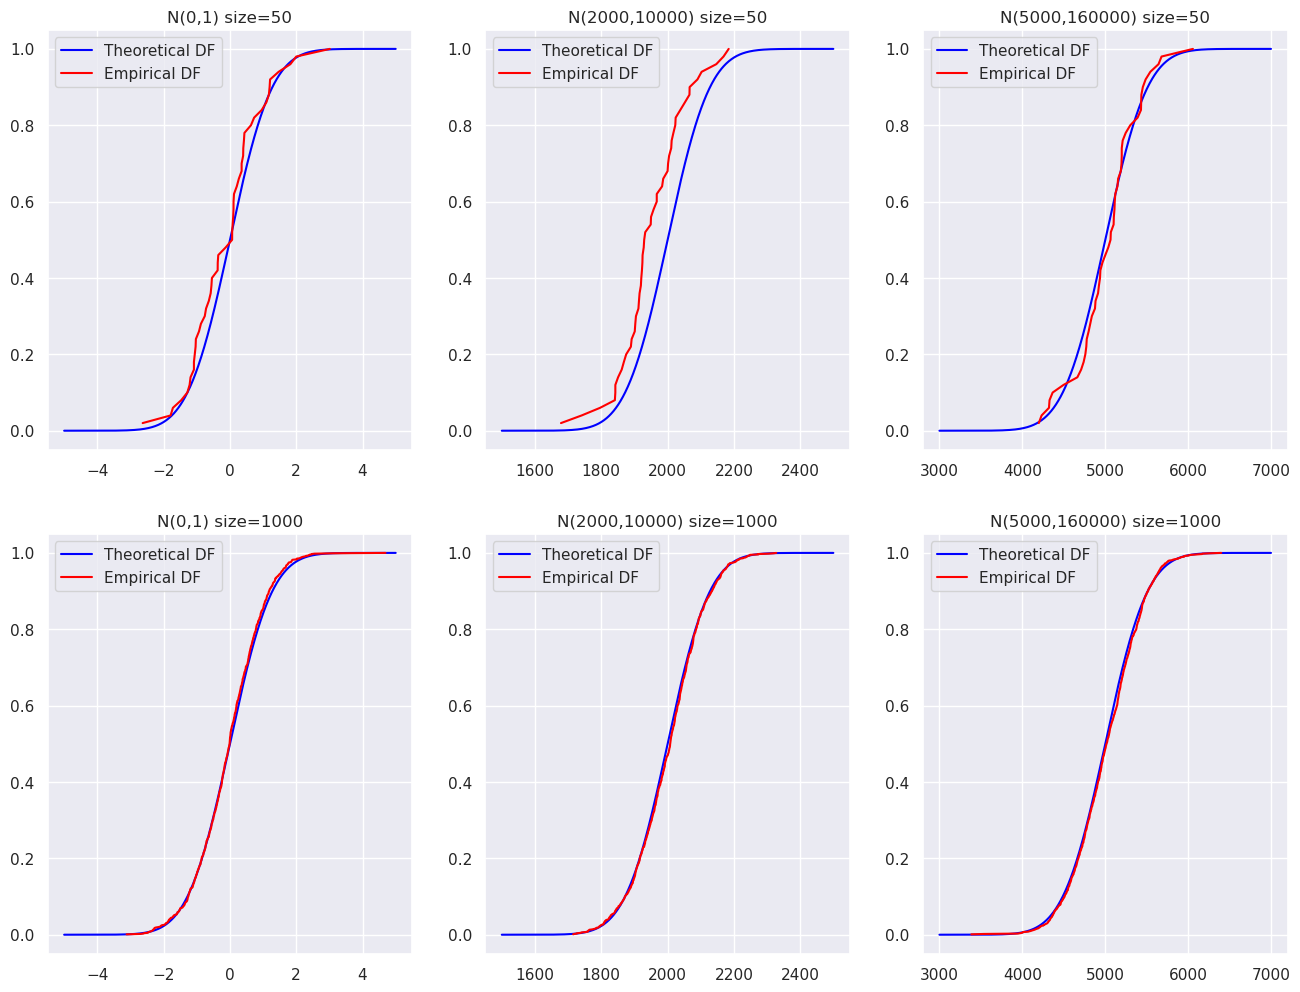

In [52]:
from statsmodels.distributions.empirical_distribution import ECDF
sns.set_style("darkgrid")
f, axes = plt.subplots(2,3, figsize=(16, 12))

for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        
        #Theoretical DF
        x_theor = np.linspace(locs[i] - 5 * scales[i],\
                              locs[i] + 5 * scales[i],\
                              num=1000)
        y_theor = norm.cdf(x_theor, locs[i], scales[i])
        sns.lineplot(x=x_theor, y=y_theor, color="blue", label='Theoretical DF', ax=axes[j, i])
        
        #Empirical DF
        ecdf = ECDF(sample)
        sns.lineplot(x=ecdf.x, y=ecdf.y, color="red", label="Empirical DF", ax=axes[j, i])
        
        plt.legend
        axes[j, i].title.set_text(f"N({locs[i]},{scales[i]**2}) size={sizes[j]}")

In [53]:
%%R
graph_distr_fun <- function(sample, mean, scale, size){
    #Empirical DF
    plot(sort(sample), (1:size)/size, type="S", col="blue", ylab="", xlab="",
        main=glue("N({mean}, {scale**2}) size={size}"))

    #Theoretical DF
    x = seq(mean - 5*scale, mean + 5*scale, by=1/100)
    lines(x, pnorm(x, mean=mean, sd=scale), type="l", col="red", lwd=2)
    
    legend("bottomright", legend = c("Empirical DF", "Theoretical DF"),
            col = c("blue", "red"), lwd = 2)
}

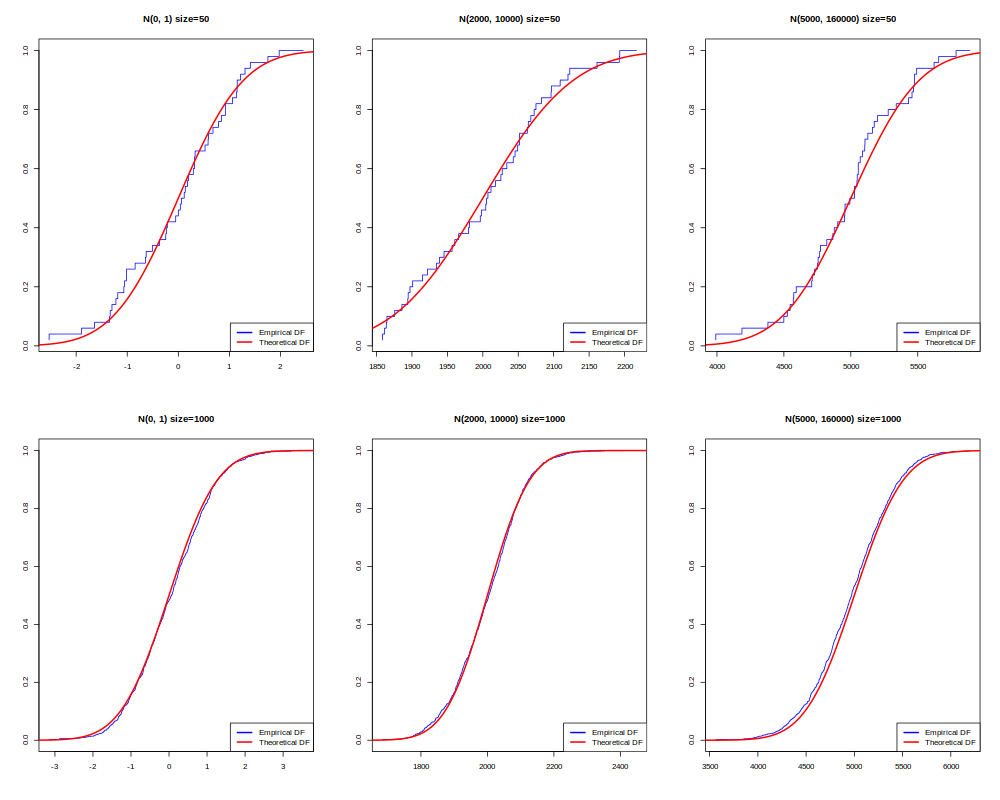

In [54]:
%%R -h 800 -w 1000
par(mfrow=c(2,3))

graph1 <- graph_distr_fun(sample1, 0, 1, 50)
graph2 <- graph_distr_fun(sample2, 2000, 100, 50)
graph3 <- graph_distr_fun(sample3, 5000, 400, 50)
graph4 <- graph_distr_fun(sample4, 0, 1, 1000)
graph5 <- graph_distr_fun(sample5, 2000, 100, 1000)
graph6 <- graph_distr_fun(sample6, 5000, 400, 1000)

# QQplot

In [55]:
from statsmodels.graphics.gofplots import qqplot

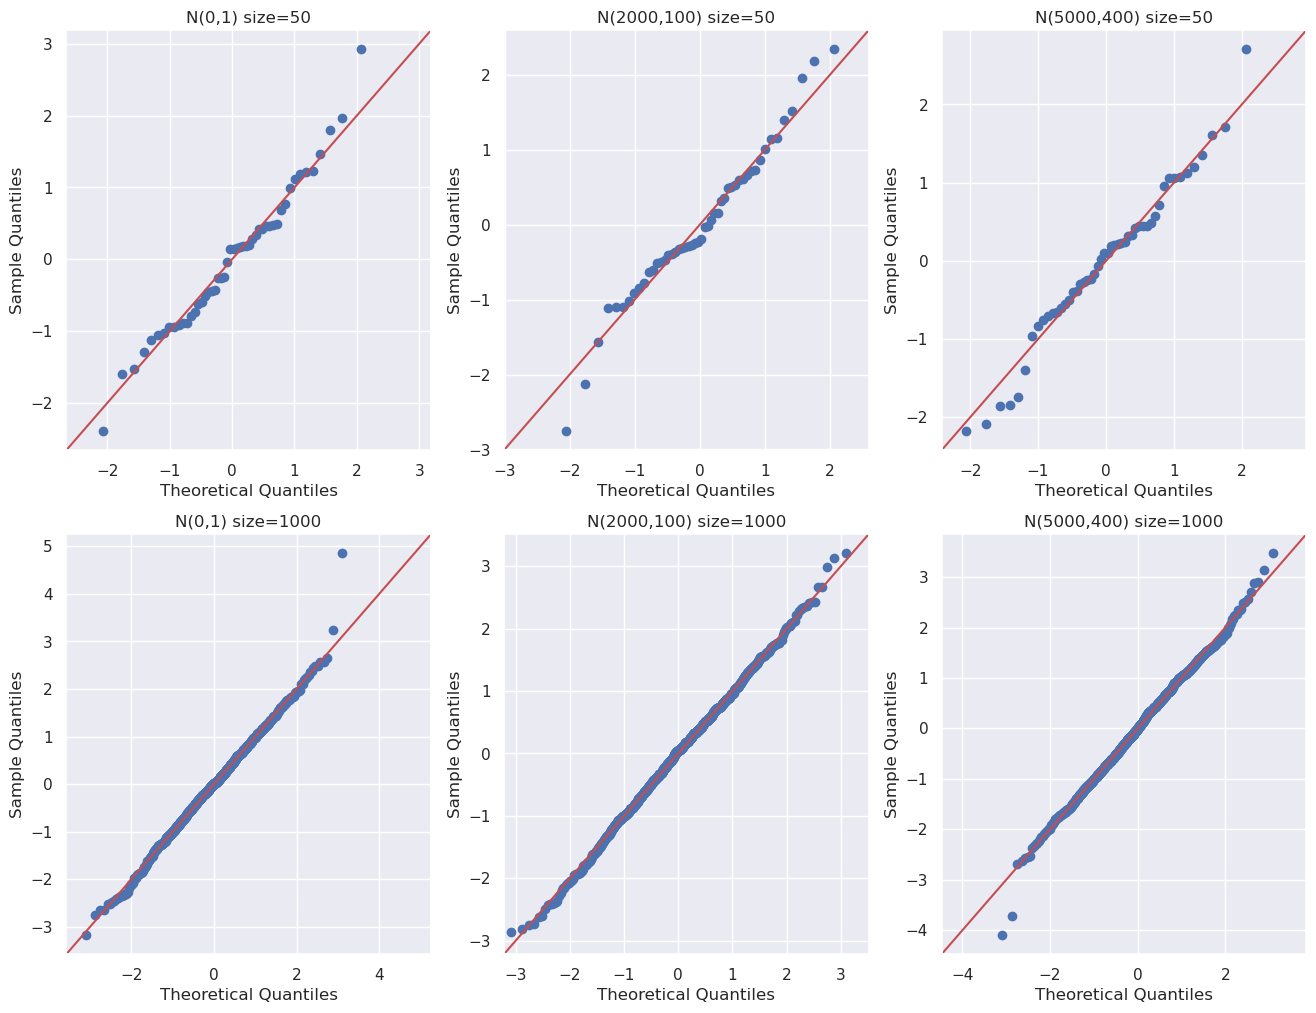

In [56]:
f, axes = plt.subplots(2,3, figsize=(16, 12))#, sharex=True, sharey=True) # 1 row, 1 column

for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]

        qqplot(sample, fit=True, line="45",ax = axes[j, i]);
        axes[j, i].title.set_text(f"N({locs[i]},{scales[i]}) size={sizes[j]}")

In [57]:
%%R
qqgraph <- function(sample, i){
  qqnorm(sample, main=glue("sample{i}"))
  qqline(sample)
}

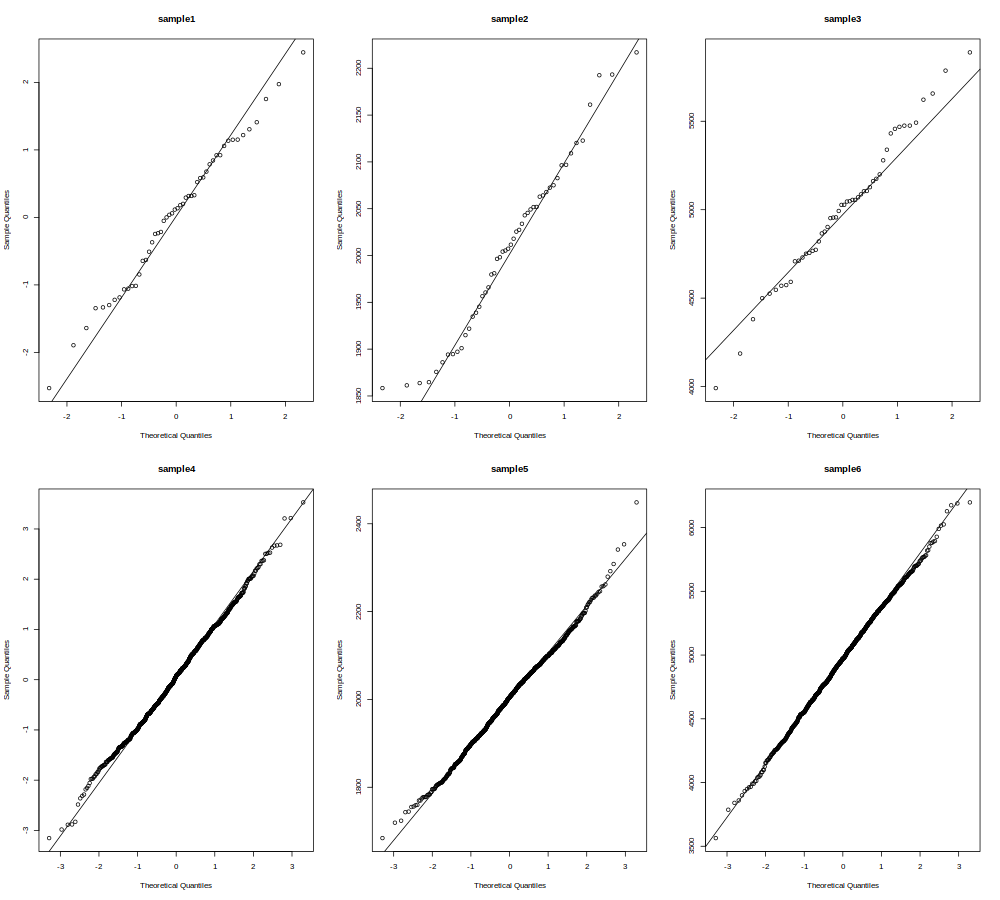

In [58]:
%%R -h 900 -w 1000
par(mfrow=c(2,3))
qqgraph(sample1, 1)
qqgraph(sample2, 2)
qqgraph(sample3, 3)
qqgraph(sample4, 4)
qqgraph(sample5, 5)
qqgraph(sample6, 6)

# Метод Огибающих

In [59]:
%%R
envelmet <- function(x, i){
  z <- (x - mean(x))/sqrt(var(x))  #  Стандартизация выборки
  x.qq <- qqnorm(z, plot.it = FALSE)
  x.qq <- lapply(x.qq, sort)
  plot(x.qq, ylim = c(-10, 10), ylab = "Z-статистики выборки", 
  xlab = "Квантили", main = glue("sample{i}"))
}

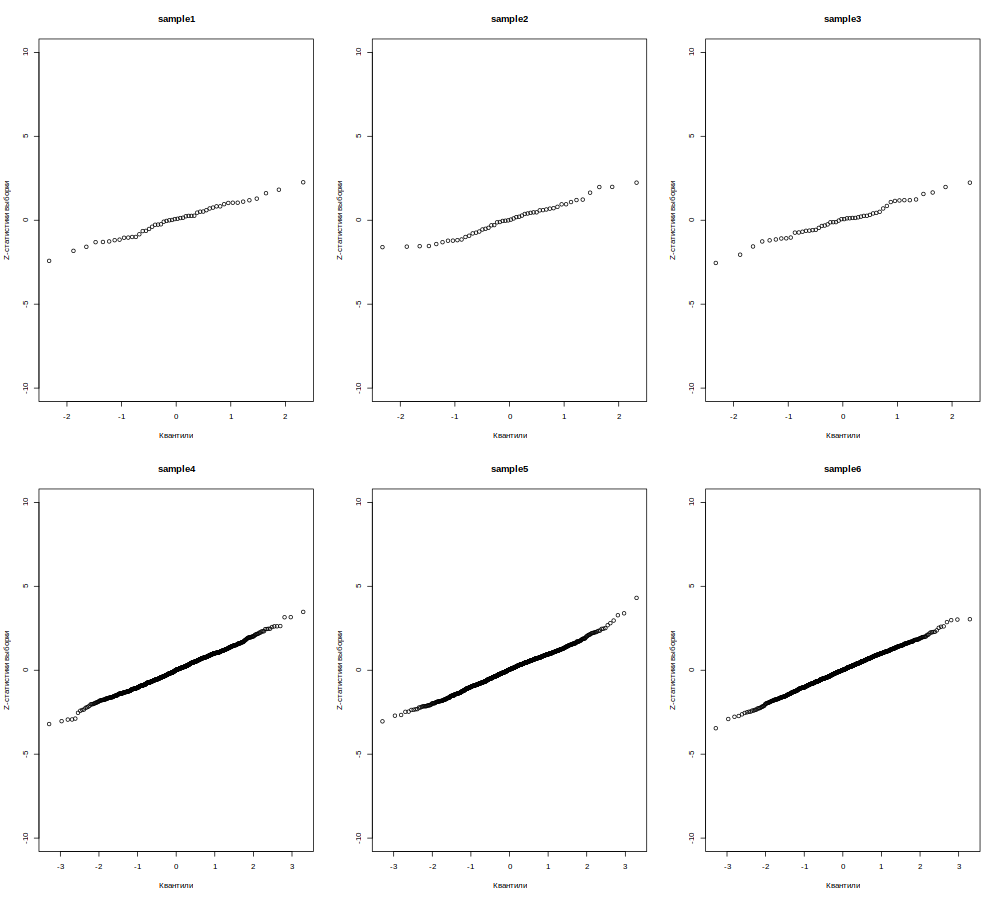

In [60]:
%%R -h 900 -w 1000
par(mfrow=c(2,3))

envelmet(sample1, 1)
envelmet(sample2, 2)
envelmet(sample3, 3)
envelmet(sample4, 4)
envelmet(sample5, 5)
envelmet(sample6, 6)

# Тест Колмогорова-Смирнова

In [61]:
for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        stat, pvalue = stats.kstest(sample, "norm", args=(locs[i], scales[i]))
        print(f"size = {sizes[j]}, mean = {locs[i]}, std = {scales[i]}\n{stat = }, {pvalue = }\n")

size = 50, mean = 0, std = 1
stat = 0.11087380395389412, pvalue = 0.5338428347822113

size = 50, mean = 2000, std = 100
stat = 0.26963764718942484, pvalue = 0.0010601636489873112

size = 50, mean = 5000, std = 400
stat = 0.09757644282275815, pvalue = 0.6912624236083766

size = 1000, mean = 0, std = 1
stat = 0.023816976233157705, pvalue = 0.6131150522766826

size = 1000, mean = 2000, std = 100
stat = 0.037436392823974596, pvalue = 0.1182161633896347

size = 1000, mean = 5000, std = 400
stat = 0.04049561991011519, pvalue = 0.07322881555579652



In [62]:
%%R
print(ks.test(sample1, "pnorm", 0, 1))
print(ks.test(sample2, "pnorm", 2000, 100))
print(ks.test(sample3, "pnorm", 5000, 400))
print(ks.test(sample4, "pnorm", 0, 1))
print(ks.test(sample5, "pnorm", 2000, 100))
print(ks.test(sample6, "pnorm", 5000, 400))


	Exact one-sample Kolmogorov-Smirnov test

data:  sample1
D = 0.084781, p-value = 0.8352
alternative hypothesis: two-sided


	Exact one-sample Kolmogorov-Smirnov test

data:  sample2
D = 0.085634, p-value = 0.8264
alternative hypothesis: two-sided


	Exact one-sample Kolmogorov-Smirnov test

data:  sample3
D = 0.075667, p-value = 0.9163
alternative hypothesis: two-sided


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample4
D = 0.035083, p-value = 0.1705
alternative hypothesis: two-sided


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample5
D = 0.029701, p-value = 0.3409
alternative hypothesis: two-sided


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample6
D = 0.042273, p-value = 0.05609
alternative hypothesis: two-sided



# Тест Андерсона-Дарлинга

Замечание statsmodels.stats.diagnostic.normal_ad возьмёт в качестве параметров распределия  
выборочное среднее и несмещённое стандартное отклонение

In [63]:
from statsmodels.stats.diagnostic import normal_ad as ad_test
for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        stat, pvalue = ad_test(sample)
        print(f"size = {sizes[j]}, mean = {locs[i]}, std = {scales[i]}\n{stat = }, {pvalue = }\n")

size = 50, mean = 0, std = 1
stat = 0.3284757445725859, pvalue = 0.5090516315036815

size = 50, mean = 2000, std = 100
stat = 0.39824534649816457, pvalue = 0.3536776707970687

size = 50, mean = 5000, std = 400
stat = 0.36570718892997434, pvalue = 0.4220963189661951

size = 1000, mean = 0, std = 1
stat = 0.26437094573930153, pvalue = 0.6960711193858642

size = 1000, mean = 2000, std = 100
stat = 0.2939425945255607, pvalue = 0.5997004513100976

size = 1000, mean = 5000, std = 400
stat = 0.3776037921613806, pvalue = 0.40805838472844136



In [64]:
%%R
library(nortest)
print(ad.test(sample1))
print(ad.test(sample2))
print(ad.test(sample3))
print(ad.test(sample4))
print(ad.test(sample5))
print(ad.test(sample6))


	Anderson-Darling normality test

data:  sample1
A = 0.24354, p-value = 0.7531


	Anderson-Darling normality test

data:  sample2
A = 0.32381, p-value = 0.5162


	Anderson-Darling normality test

data:  sample3
A = 0.26737, p-value = 0.6723


	Anderson-Darling normality test

data:  sample4
A = 0.49518, p-value = 0.214


	Anderson-Darling normality test

data:  sample5
A = 0.64638, p-value = 0.09149


	Anderson-Darling normality test

data:  sample6
A = 0.21722, p-value = 0.8423



# Тест Крамера фон Мизеса

In [65]:
for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        stat, pvalue = stats.cramervonmises(sample, 'norm', args=(locs[i], scales[i])).statistic,\
                       stats.cramervonmises(sample, 'norm', args=(locs[i], scales[i])).pvalue
        print(f"N({locs[i]},{scales[i]}) size = {sizes[j]}\n{stat = }, {pvalue = }\n")

N(0,1) size = 50
stat = 0.12652494232185194, pvalue = 0.471115074223003

N(2000,100) size = 50
stat = 1.2541789925257294, pvalue = 0.0005647028245521213

N(5000,400) size = 50
stat = 0.10316500672021948, pvalue = 0.5713490414786984

N(0,1) size = 1000
stat = 0.1331765266323705, pvalue = 0.44523128030753534

N(2000,100) size = 1000
stat = 0.22875401970998865, pvalue = 0.2180637673180137

N(5000,400) size = 1000
stat = 0.2767326345325914, pvalue = 0.1574322680760989



In [66]:
%%R
print(cvm.test(sample1))
print(cvm.test(sample2))
print(cvm.test(sample3))
print(cvm.test(sample4))
print(cvm.test(sample5))
print(cvm.test(sample6))


	Cramer-von Mises normality test

data:  sample1
W = 0.039777, p-value = 0.6787


	Cramer-von Mises normality test

data:  sample2
W = 0.036421, p-value = 0.7404


	Cramer-von Mises normality test

data:  sample3
W = 0.045425, p-value = 0.5748


	Cramer-von Mises normality test

data:  sample4
W = 0.073263, p-value = 0.2533


	Cramer-von Mises normality test

data:  sample5
W = 0.10042, p-value = 0.1108


	Cramer-von Mises normality test

data:  sample6
W = 0.030303, p-value = 0.8431



# Тест Лиллиефорса

In [67]:
from statsmodels.stats.diagnostic import lilliefors
for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        stat, pvalue = lilliefors(sample)
        print(f"N({locs[i]},{scales[i]}) size = {sizes[j]}\n{stat = }, {pvalue = }\n")

N(0,1) size = 50
stat = 0.09094304530212571, pvalue = 0.38251689669786665

N(2000,100) size = 50
stat = 0.09673490336287588, pvalue = 0.285091826676084

N(5000,400) size = 50
stat = 0.07740043368658112, pvalue = 0.6327170990270895

N(0,1) size = 1000
stat = 0.018134858368808904, pvalue = 0.6673259768130475

N(2000,100) size = 1000
stat = 0.023567129594584513, pvalue = 0.2495968600544056

N(5000,400) size = 1000
stat = 0.024223599927328254, pvalue = 0.22257001590552922



In [68]:
%%R
print(lillie.test(sample1))
print(lillie.test(sample2))
print(lillie.test(sample3))
print(lillie.test(sample4))
print(lillie.test(sample5))
print(lillie.test(sample6))


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample1
D = 0.080018, p-value = 0.5873


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample2
D = 0.07425, p-value = 0.7022


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample3
D = 0.075788, p-value = 0.6719


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample4
D = 0.021112, p-value = 0.3447


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample5
D = 0.022622, p-value = 0.246


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample6
D = 0.014012, p-value = 0.905



# Тест Шапиро-Уилка

Ограничение на размер выборки 5000. Мы проходим.

In [69]:
for j in range(len(sizes)):
    for i in range(len(locs)):
        if j:
            sample = samples_big[i]
        else:
            sample = samples_small[i]
        stat, pvalue = stats.shapiro(sample)
        print(f"N({locs[i]},{scales[i]}) size = {sizes[j]}\n{stat = }, {pvalue = }\n")

N(0,1) size = 50
stat = 0.9832391738891602, pvalue = 0.6940747499465942

N(2000,100) size = 50
stat = 0.9803583025932312, pvalue = 0.5671716928482056

N(5000,400) size = 50
stat = 0.9796740412712097, pvalue = 0.5382983088493347

N(0,1) size = 1000
stat = 0.9969052076339722, pvalue = 0.04884222522377968

N(2000,100) size = 1000
stat = 0.9987080693244934, pvalue = 0.6939663290977478

N(5000,400) size = 1000
stat = 0.9978259205818176, pvalue = 0.2171912044286728



In [70]:
%%R
print(shapiro.test(sample1))
print(shapiro.test(sample2))
print(shapiro.test(sample3))
print(shapiro.test(sample4))
print(shapiro.test(sample5))
print(shapiro.test(sample6))


	Shapiro-Wilk normality test

data:  sample1
W = 0.98986, p-value = 0.9429


	Shapiro-Wilk normality test

data:  sample2
W = 0.97013, p-value = 0.2342


	Shapiro-Wilk normality test

data:  sample3
W = 0.98848, p-value = 0.9043


	Shapiro-Wilk normality test

data:  sample4
W = 0.99808, p-value = 0.3174


	Shapiro-Wilk normality test

data:  sample5
W = 0.99677, p-value = 0.03891


	Shapiro-Wilk normality test

data:  sample6
W = 0.99901, p-value = 0.8761



# 6. Анализ данных с помощью графиков квантилей, метода огибающих, а также стандартных процедур проверки гипотез о нормальности на реальных данных.

### Построим qqplot для некоторых признаков. Видим, что распределение признаков отвечающих за габариты (оссобенно за длину и ширину) больше похожи на нормальные. 

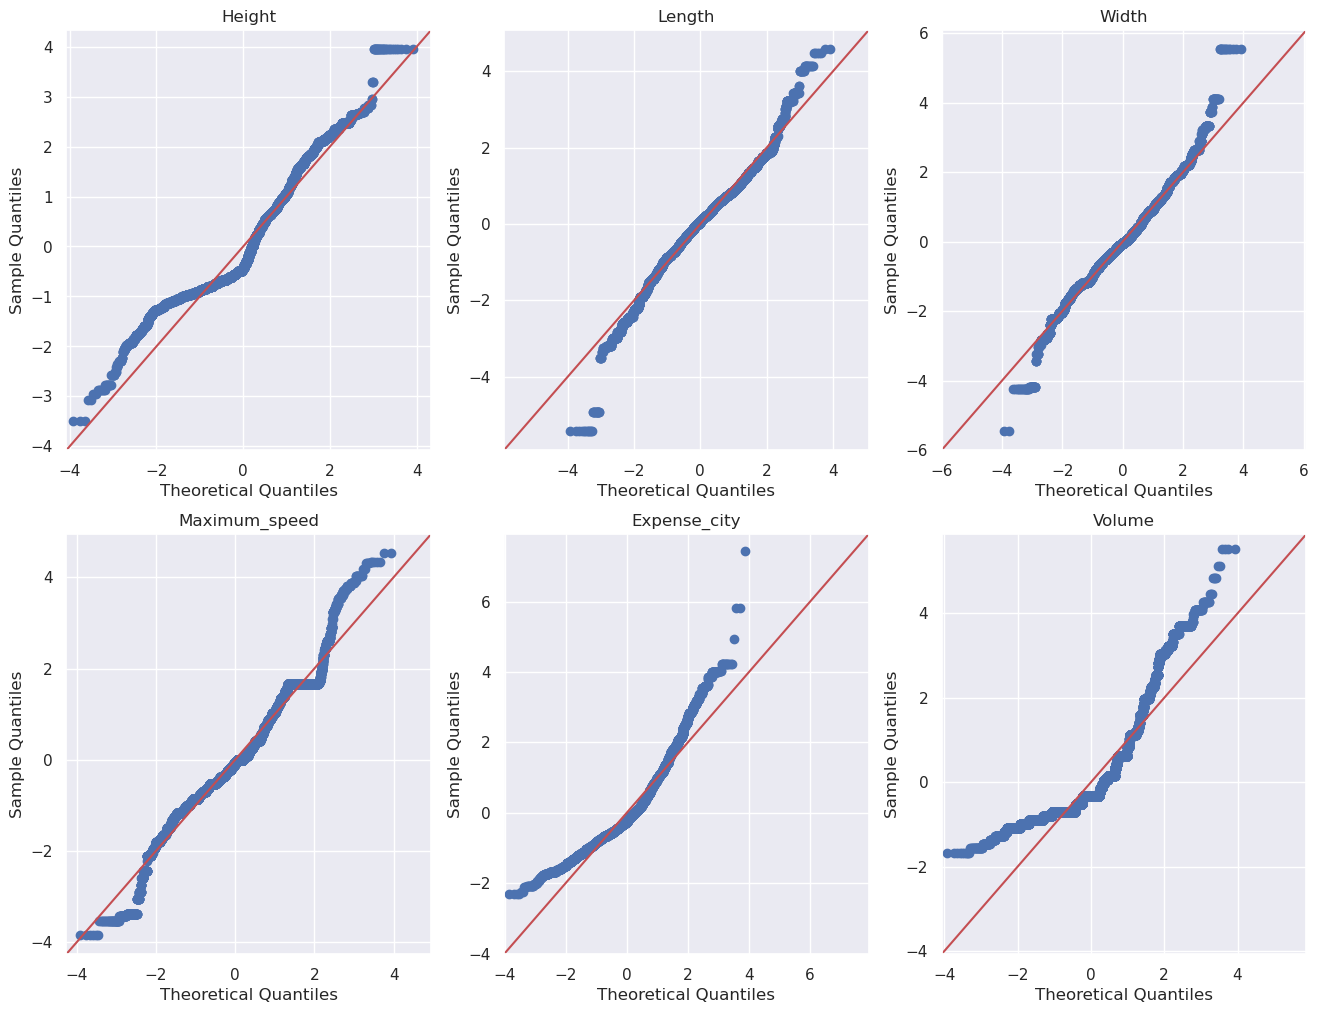

In [71]:
f, axes = plt.subplots(2,3, figsize=(16, 12))#, sharex=True, sharey=True) # 1 row, 1 column

qqplot(df.Height, fit=True, line="45",ax = axes[0, 0]);
axes[0, 0].title.set_text("Height")

qqplot(df.Length, fit=True, line="45",ax = axes[0, 1]);
axes[0, 1].title.set_text("Length")

qqplot(df.Width, fit=True, line="45",ax = axes[0, 2]);
axes[0, 2].title.set_text("Width")

qqplot(df.Maximum_speed, fit=True, line="45",ax = axes[1, 0]);
axes[1, 0].title.set_text("Maximum_speed")

qqplot(df.Expense_city[df.Expense_city != 0], fit=True, line="45",ax = axes[1, 1]);
axes[1, 1].title.set_text("Expense_city")

qqplot(df.Volume[df.Volume != 0], fit=True, line="45",ax = axes[1, 2]);
axes[1, 2].title.set_text("Volume")

In [72]:
%%R
qqgraph <- function(sample, name){
  qqnorm(sample, main=name)
  qqline(sample)
}

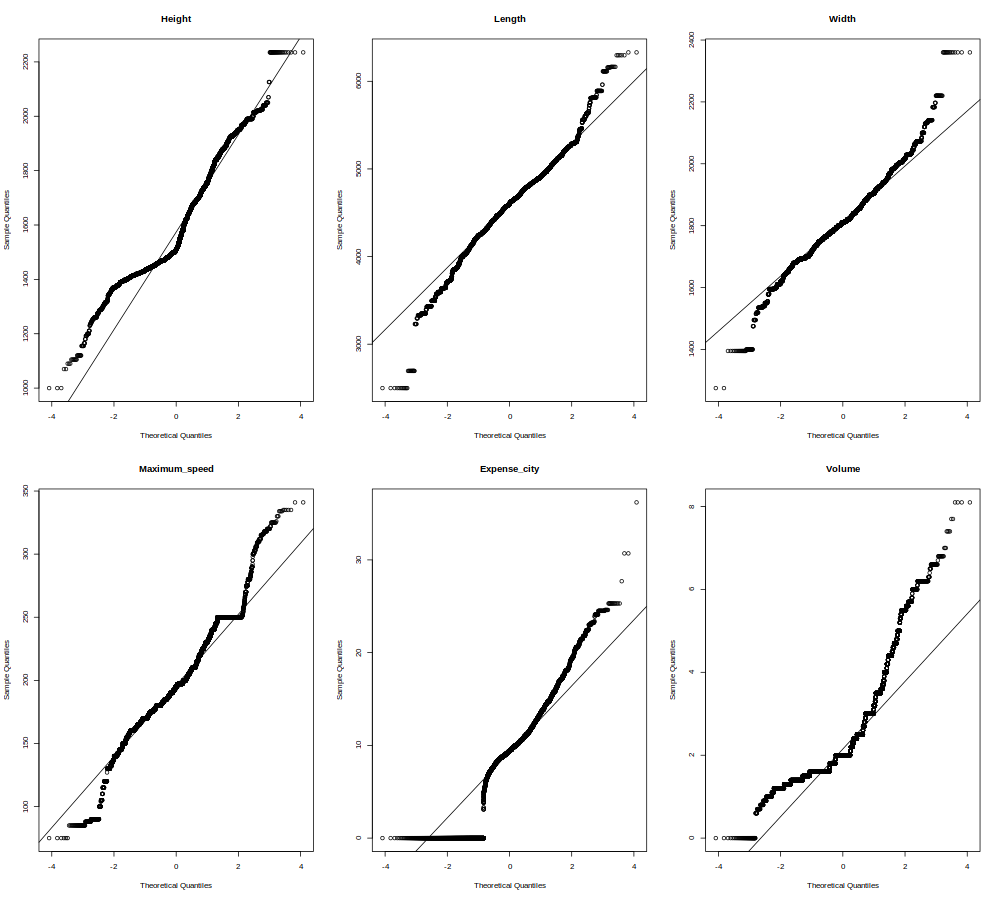

In [73]:
%%R -h 900 -w 1000
par(mfrow=c(2,3))

qqgraph(df$Height, "Height")
qqgraph(df$Length, "Length")
qqgraph(df$Width, "Width")
qqgraph(df$Maximum_speed, "Maximum_speed")
qqgraph(df$Expense_city, "Expense_city")
qqgraph(df$Volume, "Volume")

### Создадим выборки для длины, ширины и проведём на них тест на нормальность.

In [74]:
sample_width = df.Width
sample_length = df.Length

In [75]:
%%R
sample_width <- df$Width
sample_length <- df$Length

### Тест Колмогорова-Смирнова

In [76]:
stat, pvalue = stats.kstest(sample_width, "norm", args=(sample_width.mean(), sample_width.std(ddof=1)))
print(f"Width: {stat = }, {pvalue = }\n")

stat, pvalue = stats.kstest(sample_length, "norm", args=(sample_length.mean(), sample_length.std(ddof=1)))
print(f"Length: {stat = }, {pvalue = }\n")

Width: stat = 0.05474346245739292, pvalue = 1.4203200058561878e-59

Length: stat = 0.043192087255885914, pvalue = 3.070807224858721e-37



In [77]:
%%R
print(ks.test(sample_width, "pnorm", mean(sample_width), sd(sample_width)))
print(ks.test(sample_length, "pnorm", mean(sample_length), sd(sample_length)))


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample_width
D = 0.054743, p-value < 2.2e-16
alternative hypothesis: two-sided


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample_length
D = 0.043192, p-value < 2.2e-16
alternative hypothesis: two-sided



In addition: Warning messages:
1: In ks.test.default(sample_width, "pnorm", mean(sample_width), sd(sample_width)) :
  ties should not be present for the Kolmogorov-Smirnov test
2: In ks.test.default(sample_length, "pnorm", mean(sample_length),  :
  ties should not be present for the Kolmogorov-Smirnov test


### Тест Андерсона-Дарлинга 

In [78]:
stat, pvalue = ad_test(sample_width)
print(f"Width: {stat = }, {pvalue = }\n")

stat, pvalue = ad_test(sample_length)
print(f"Length: {stat = }, {pvalue = }\n")

Width: stat = 60.718621700780204, pvalue = 0.0

Length: stat = 79.35115163918817, pvalue = 0.0



In [79]:
%%R
print(ad.test(sample_width))
print(ad.test(sample_length))


	Anderson-Darling normality test

data:  sample_width
A = 60.719, p-value < 2.2e-16


	Anderson-Darling normality test

data:  sample_length
A = 79.351, p-value < 2.2e-16



### Тест Лиллиефорса

In [80]:
stat, pvalue = lilliefors(sample_width)
print(f"Width: {stat = }, {pvalue = }\n")

stat, pvalue = lilliefors(sample_length)
print(f"Length: {stat = }, {pvalue = }\n")

Width: stat = 0.0547434624573927, pvalue = 0.0009999999999998899

Length: stat = 0.04319208725588569, pvalue = 0.0009999999999998899



In [81]:
%%R
print(lillie.test(sample_width))
print(lillie.test(sample_length))


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample_width
D = 0.054743, p-value < 2.2e-16


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  sample_length
D = 0.043192, p-value < 2.2e-16



### Тест Шапиро-Уилка

In [82]:
stat, pvalue = stats.shapiro(sample_width)
print(f"Width: {stat = }, {pvalue = }\n")

stat, pvalue = stats.shapiro(sample_length)
print(f"Length: {stat = }, {pvalue = }\n")

Width: stat = 0.9865264296531677, pvalue = 4.5100791074294237e-41

Length: stat = 0.9828482866287231, pvalue = 5.605193857299268e-45



In [83]:
%%R
print(shapiro.test(sample(sample_width, 5000)))
print(shapiro.test(sample(sample_length, 5000)))


	Shapiro-Wilk normality test

data:  sample(sample_width, 5000)
W = 0.98363, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  sample(sample_length, 5000)
W = 0.98252, p-value < 2.2e-16



### Как видим выше, несмотря на неплохие графики qqplot все тесты уверенно отвергают гипотезу о том, что признаки распределны нормально. 

# 7.

# 8.  Исследование корреляционных взаимосвязях в данных с помощью коэффициентов корреляции Пирсона, Спирмена и Кендалла.

In [371]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import operator

### Раздеоим признаки на количественные и качественные.

In [372]:
numeric_features = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].drop(['Price',\
        'Speed_to_100', 'Cylinders', 'Transmissions', "Seats", "Doors", "Restyling"]).index.values
categorical_features = df.dtypes[(df.dtypes == 'object') | (df.dtypes.index.isin(['Cylinders',\
    'Transmissions', "Seats", "Doors", "Restyling"]))].drop(['mark', 'Country', 'Color', 'Generation', 'Model', \
    'Front_Suspension_type']).index.values

## Корреляция Пиросона.

## Посмотрим на корреляцию с ценой автомобиля.

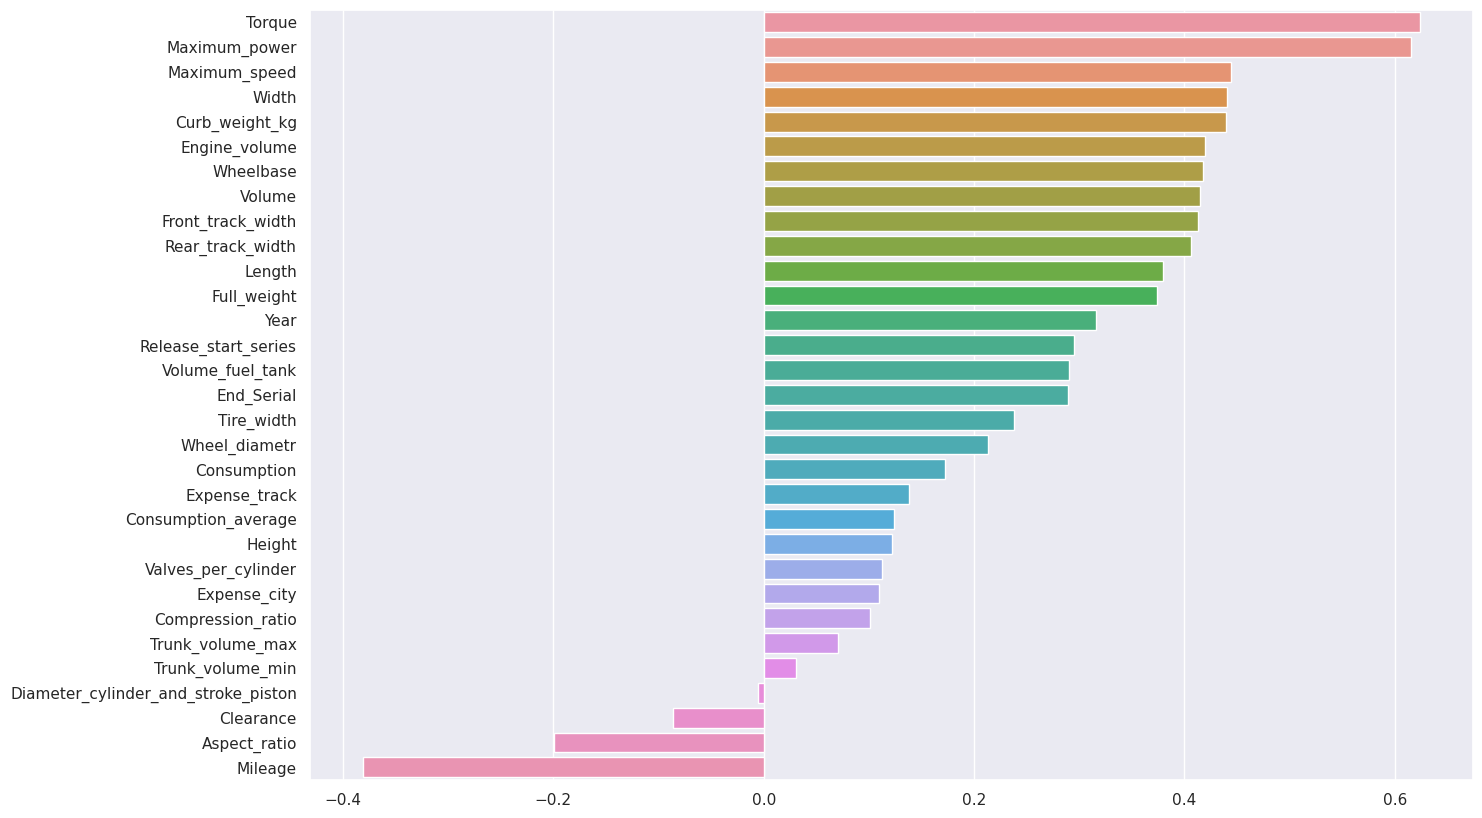

In [374]:
correlations_pirson = df[numeric_features].corrwith(df.Price, method='pearson').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

### Построим графики зависимости цены от признаков с самой высокой корреляцией.

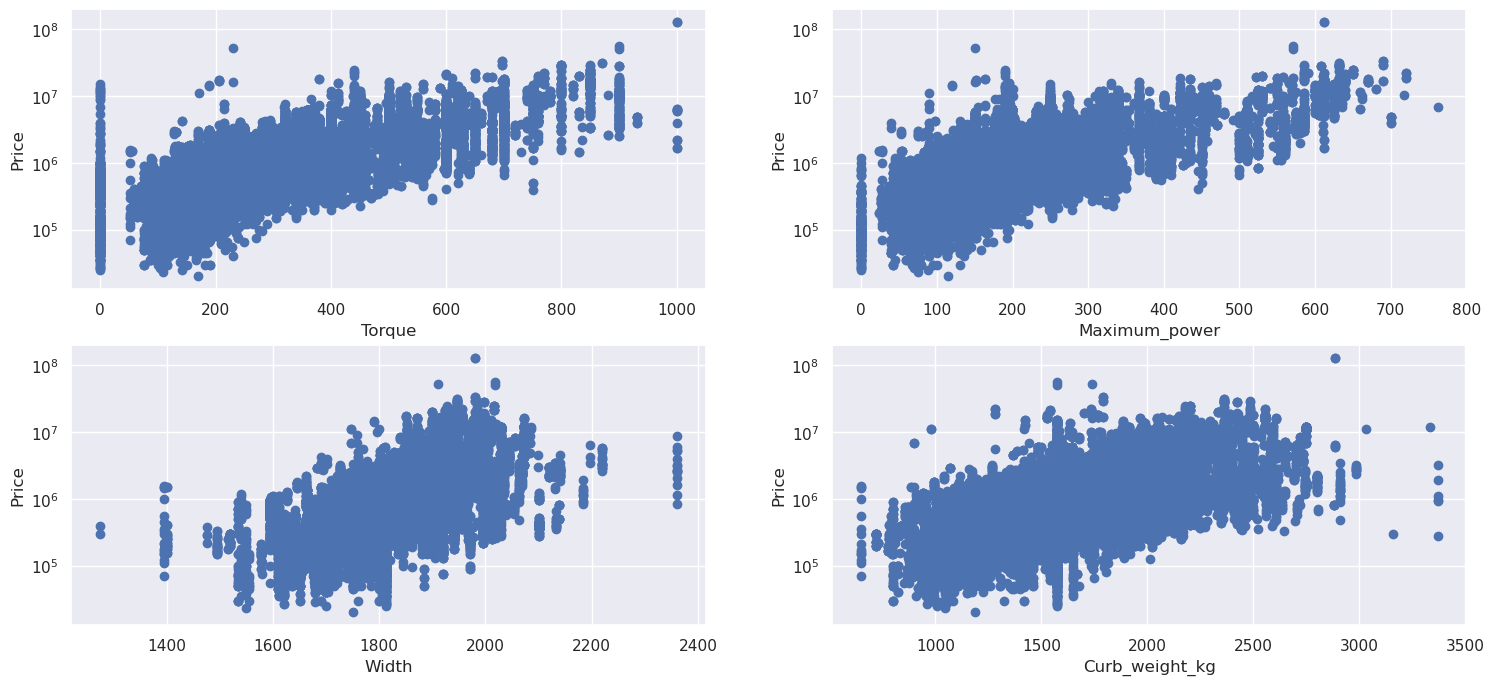

In [375]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))
for i, feature in enumerate(['Torque', 'Maximum_power', 'Width', 'Curb_weight_kg']):
    axs[(i+2)//4, i%2].scatter(df[feature], df.Price)
    axs[(i+2)//4, i%2].set_xlabel(feature)
    axs[(i+2)//4, i%2].set_ylabel("Price")
    axs[(i+2)//4, i%2].set(yscale="log")

In [376]:
%%R
print(cor.test(df$Price, df$Torque, method = 'pearson'))
print(cor.test(df$Price, df$Maximum_power, method = 'pearson'))


	Pearson's product-moment correlation

data:  df$Price and df$Torque
t = 145.54, df = 33262, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6171428 0.6302740
sample estimates:
      cor 
0.6237524 


	Pearson's product-moment correlation

data:  df$Price and df$Maximum_power
t = 142.45, df = 33262, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6088489 0.6221982
sample estimates:
      cor 
0.6155677 



## Корреляция  Спирмена.

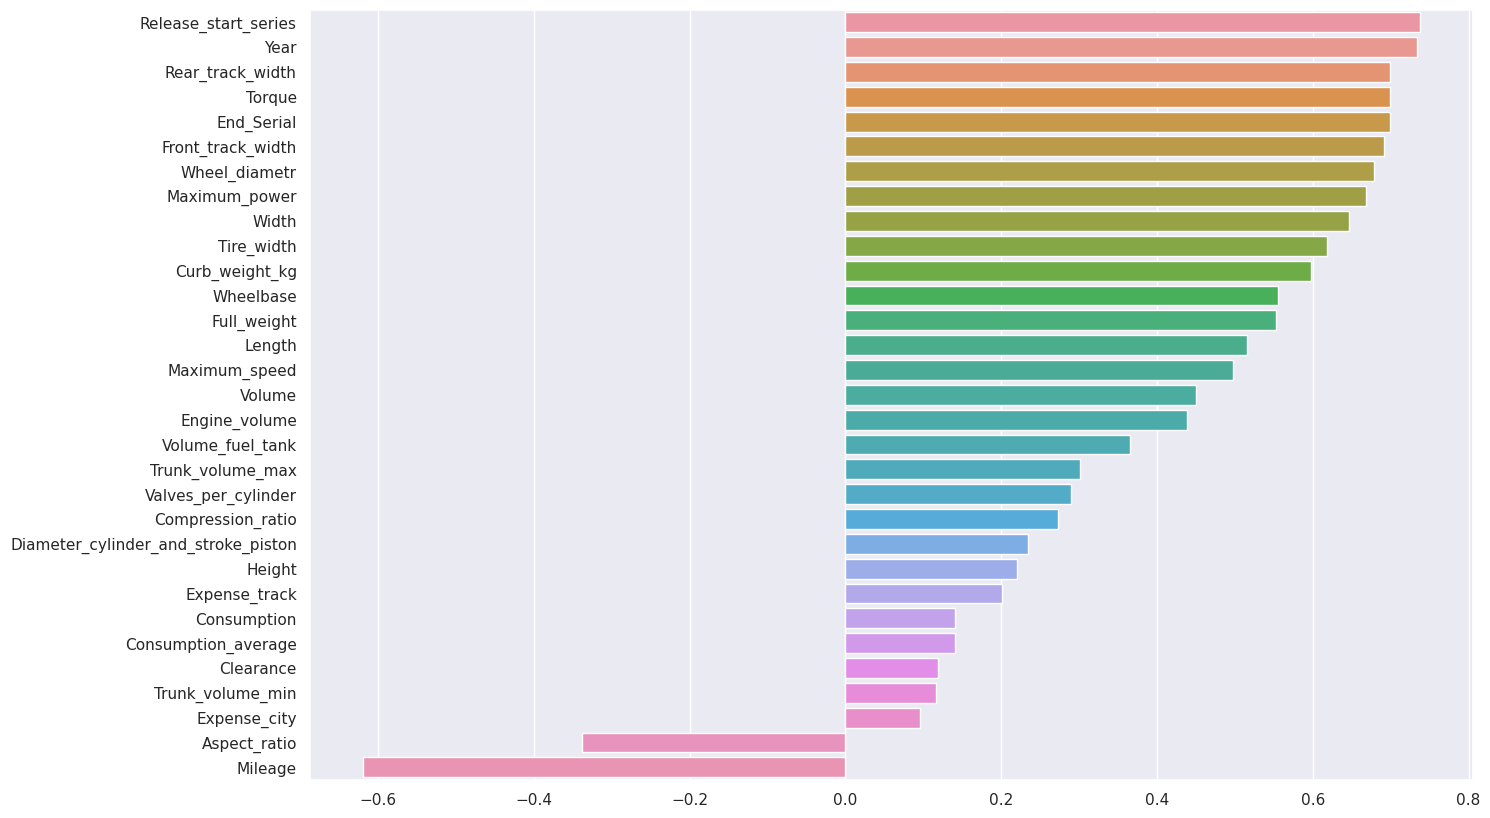

In [377]:
correlations_pirson = df[numeric_features].corrwith(df.Price, method='spearman').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

In [378]:
%%R
print(cor.test(df$Price, df$Torque, method = 'spearman'))
print(cor.test(df$Price, df$Year, method = 'spearman'))


	Spearman's rank correlation rho

data:  df$Price and df$Torque
S = 1.8475e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6988266 


	Spearman's rank correlation rho

data:  df$Price and df$Year
S = 1.6307e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.734174 



In addition: Warning messages:
1: In cor.test.default(df$Price, df$Torque, method = "spearman") :
  Cannot compute exact p-value with ties
2: In cor.test.default(df$Price, df$Year, method = "spearman") :
  Cannot compute exact p-value with ties


## Корреляция Кендалла.

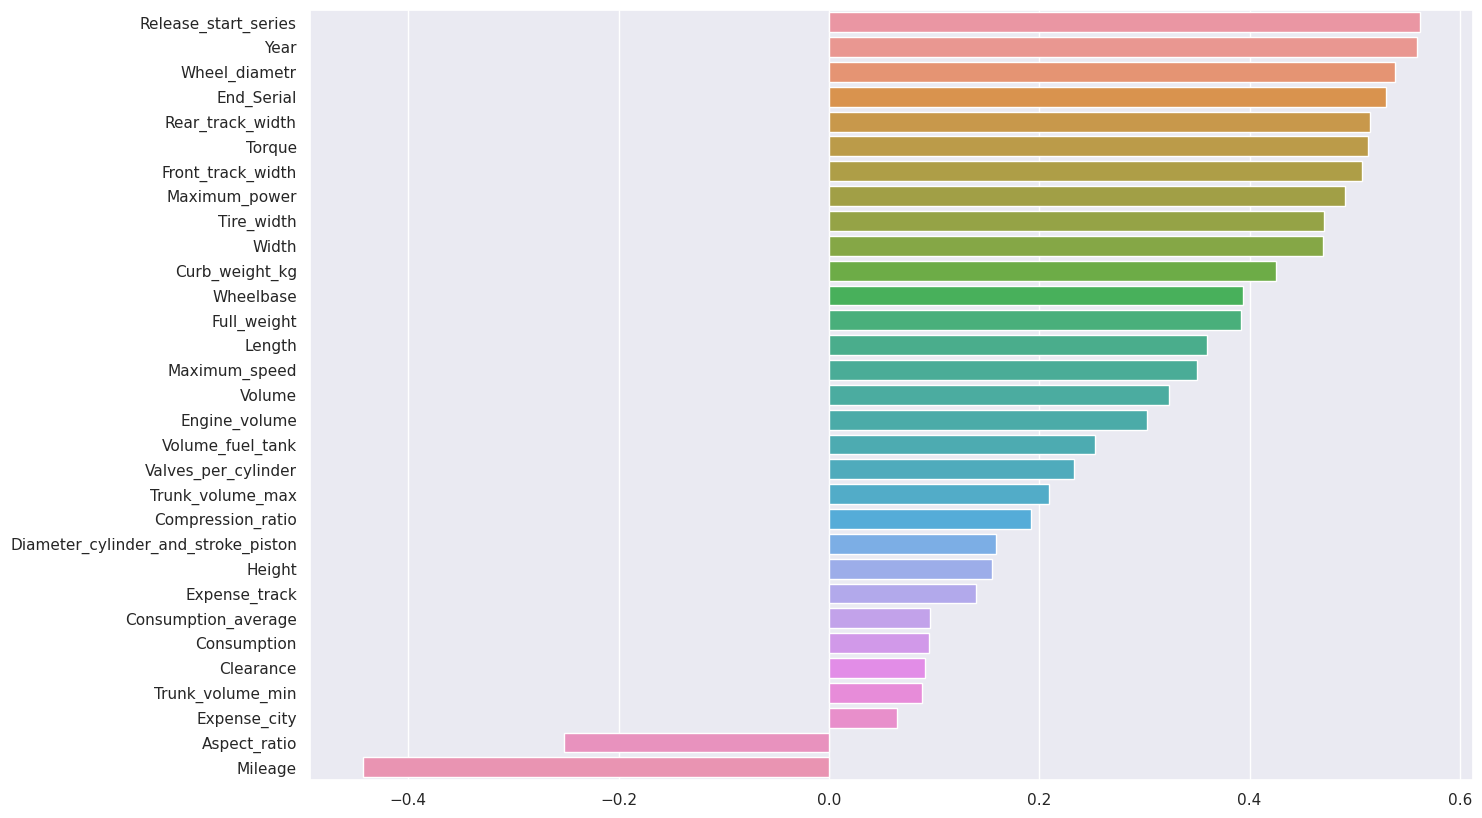

In [379]:
correlations_pirson = df[numeric_features].corrwith(df.Price, method='kendall').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

In [380]:
%%R
print(cor.test(df$Price, df$Torque, method = 'kendall'))
print(cor.test(df$Price, df$Year, method = 'kendall'))


	Kendall's rank correlation tau

data:  df$Price and df$Torque
z = 139.29, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.5122107 


	Kendall's rank correlation tau

data:  df$Price and df$Year
z = 149.07, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.5595668 



## Иследование корреляции со временем разгона до 100 км/ч

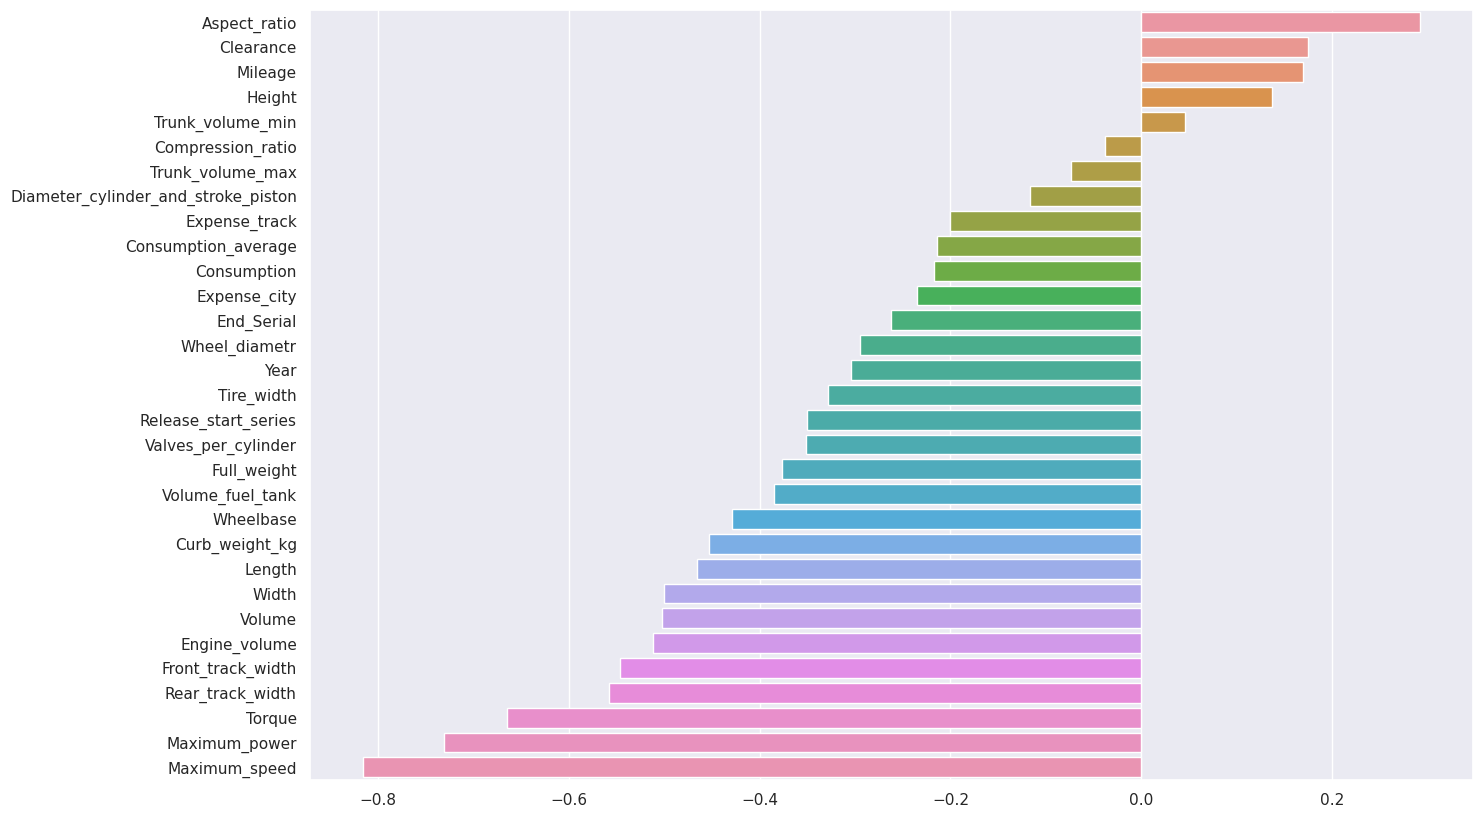

In [381]:
correlations_pirson = df[numeric_features].corrwith(df.Speed_to_100, method='pearson').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

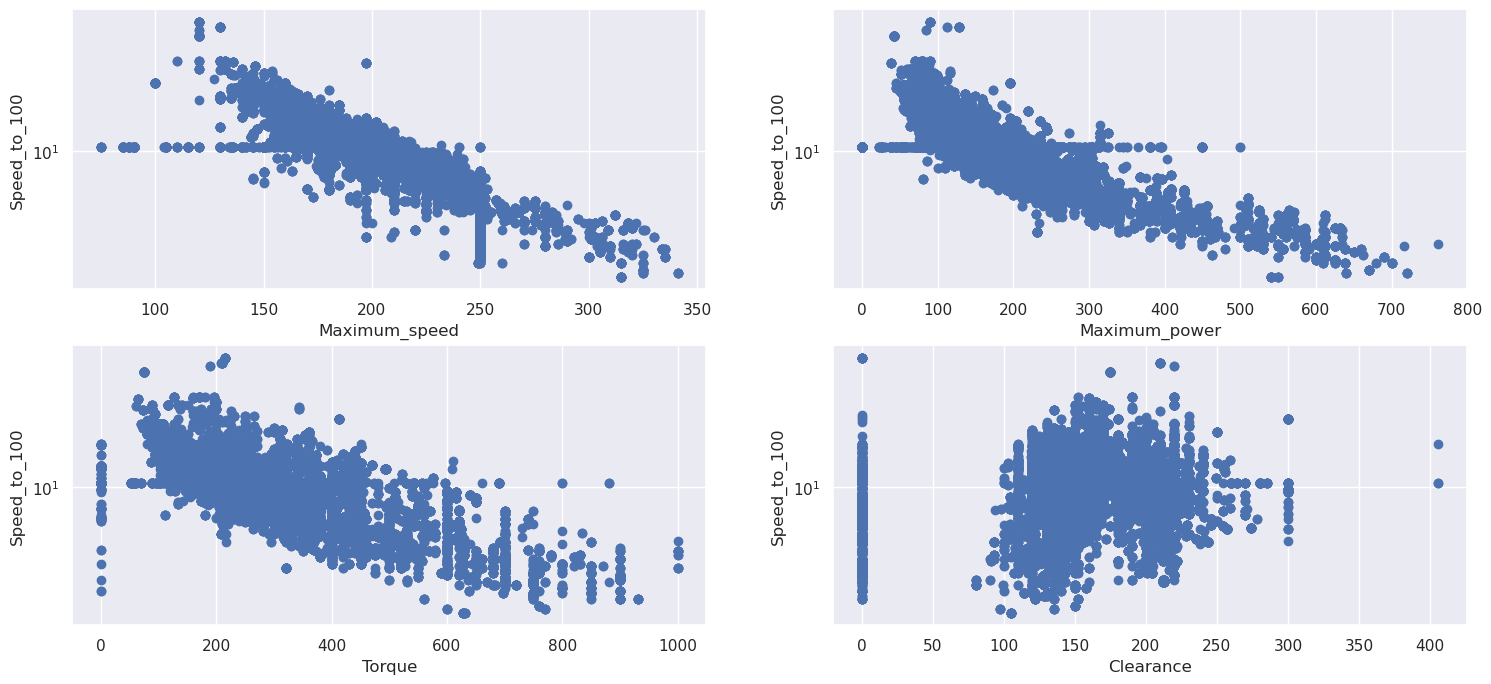

In [382]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))
for i, feature in enumerate(['Maximum_speed', 'Maximum_power', 'Torque', 'Clearance']):
    axs[(i+2)//4, i%2].scatter(df[feature], df.Speed_to_100)
    axs[(i+2)//4, i%2].set_xlabel(feature)
    axs[(i+2)//4, i%2].set_ylabel("Speed_to_100")
    axs[(i+2)//4, i%2].set(yscale="log")

In [383]:
%%R
print(cor.test(df$Price, df$Torque, method = 'pearson'))
print(cor.test(df$Price, df$Year, method = 'pearson'))


	Pearson's product-moment correlation

data:  df$Price and df$Torque
t = 145.54, df = 33262, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6171428 0.6302740
sample estimates:
      cor 
0.6237524 


	Pearson's product-moment correlation

data:  df$Price and df$Year
t = 60.668, df = 33262, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3059351 0.3252868
sample estimates:
      cor 
0.3156437 



## Корреляция Спирмена.

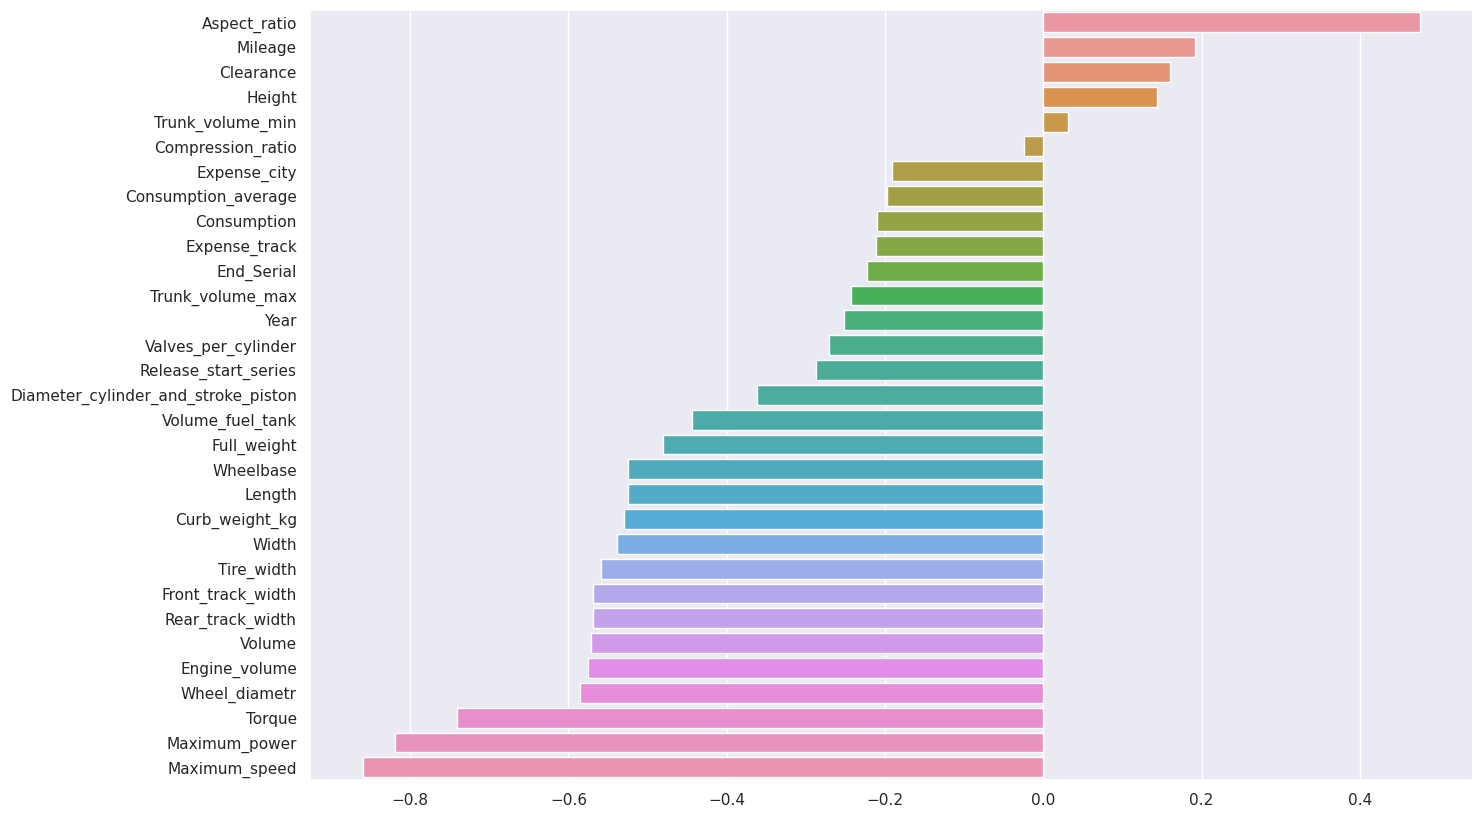

In [384]:
correlations_pirson = df[numeric_features].corrwith(df.Speed_to_100, method='spearman').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

In [100]:
%%R
print(cor.test(df$Price, df$Torque, method = 'spearman'))
print(cor.test(df$Price, df$Year, method = 'spearman'))


	Spearman's rank correlation rho

data:  df$Price and df$Torque
S = 6.1868e+11, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6827325 


	Spearman's rank correlation rho

data:  df$Price and df$Year
S = 5.4267e+11, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7217132 



In addition: Warning messages:
1: In cor.test.default(df$Price, df$Torque, method = "spearman") :
  Cannot compute exact p-value with ties
2: In cor.test.default(df$Price, df$Year, method = "spearman") :
  Cannot compute exact p-value with ties


## Корреляция Кендалла.

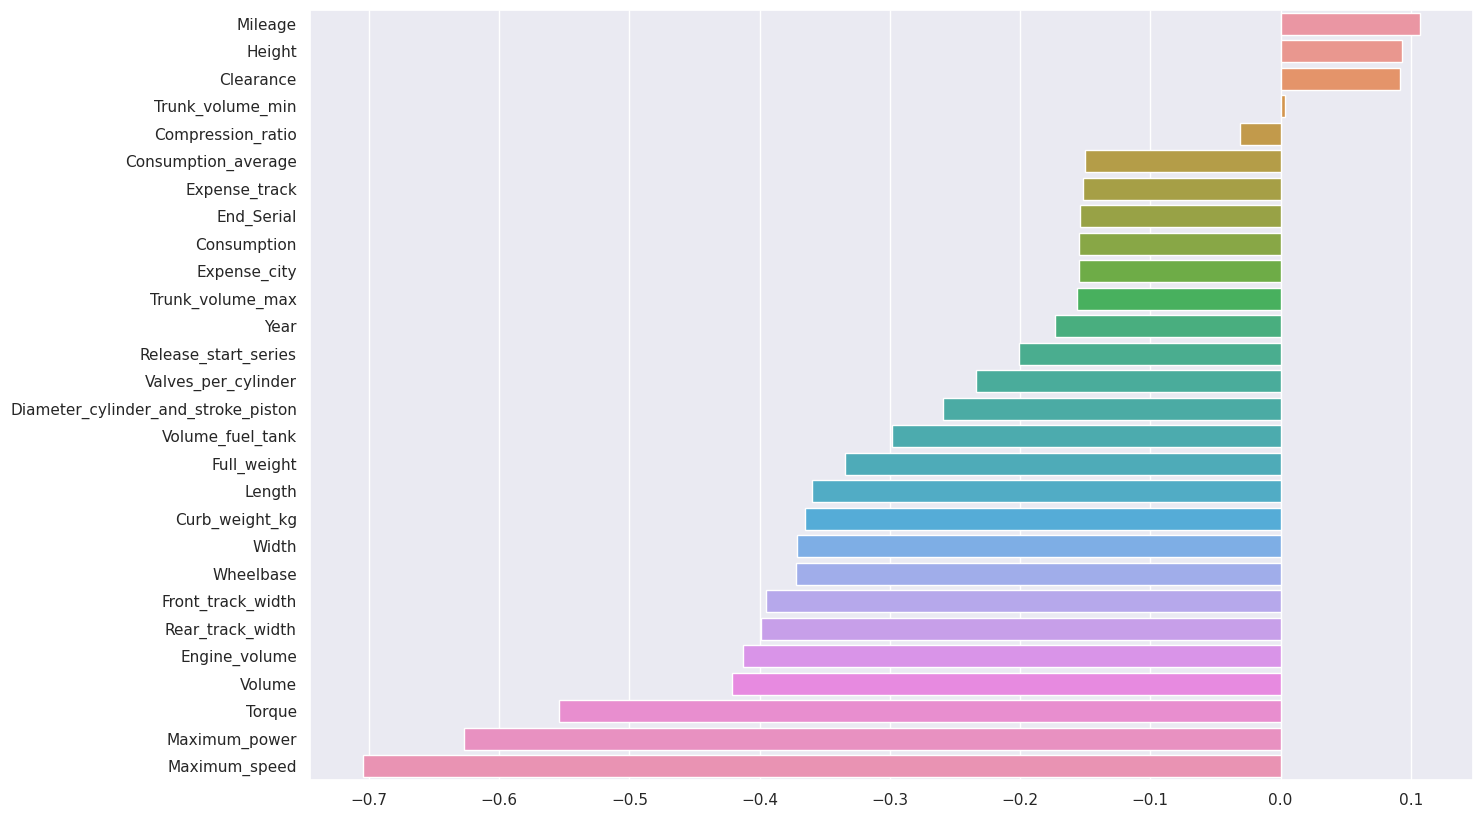

In [101]:
correlations_pirson = df[numeric_features].corrwith(df.Speed_to_100, method='kendall').sort_values(ascending=False)
plot = sns.barplot(y=correlations_pirson.index, x=correlations_pirson)
plot.figure.set_size_inches(15, 10)

In [102]:
%%R
print(cor.test(df$Price, df$Torque, method = 'kendall'))
print(cor.test(df$Price, df$Year, method = 'kendall'))


	Kendall's rank correlation tau

data:  df$Price and df$Torque
z = 111.74, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.4972777 


	Kendall's rank correlation tau

data:  df$Price and df$Year
z = 121.08, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.5484853 



# 8.

# 10. Проверка наличия мультиколлинеарности в данных с помощью корреляционной матрицы и фактора инфляции дисперсии.

## Построим корреляционную матрицу

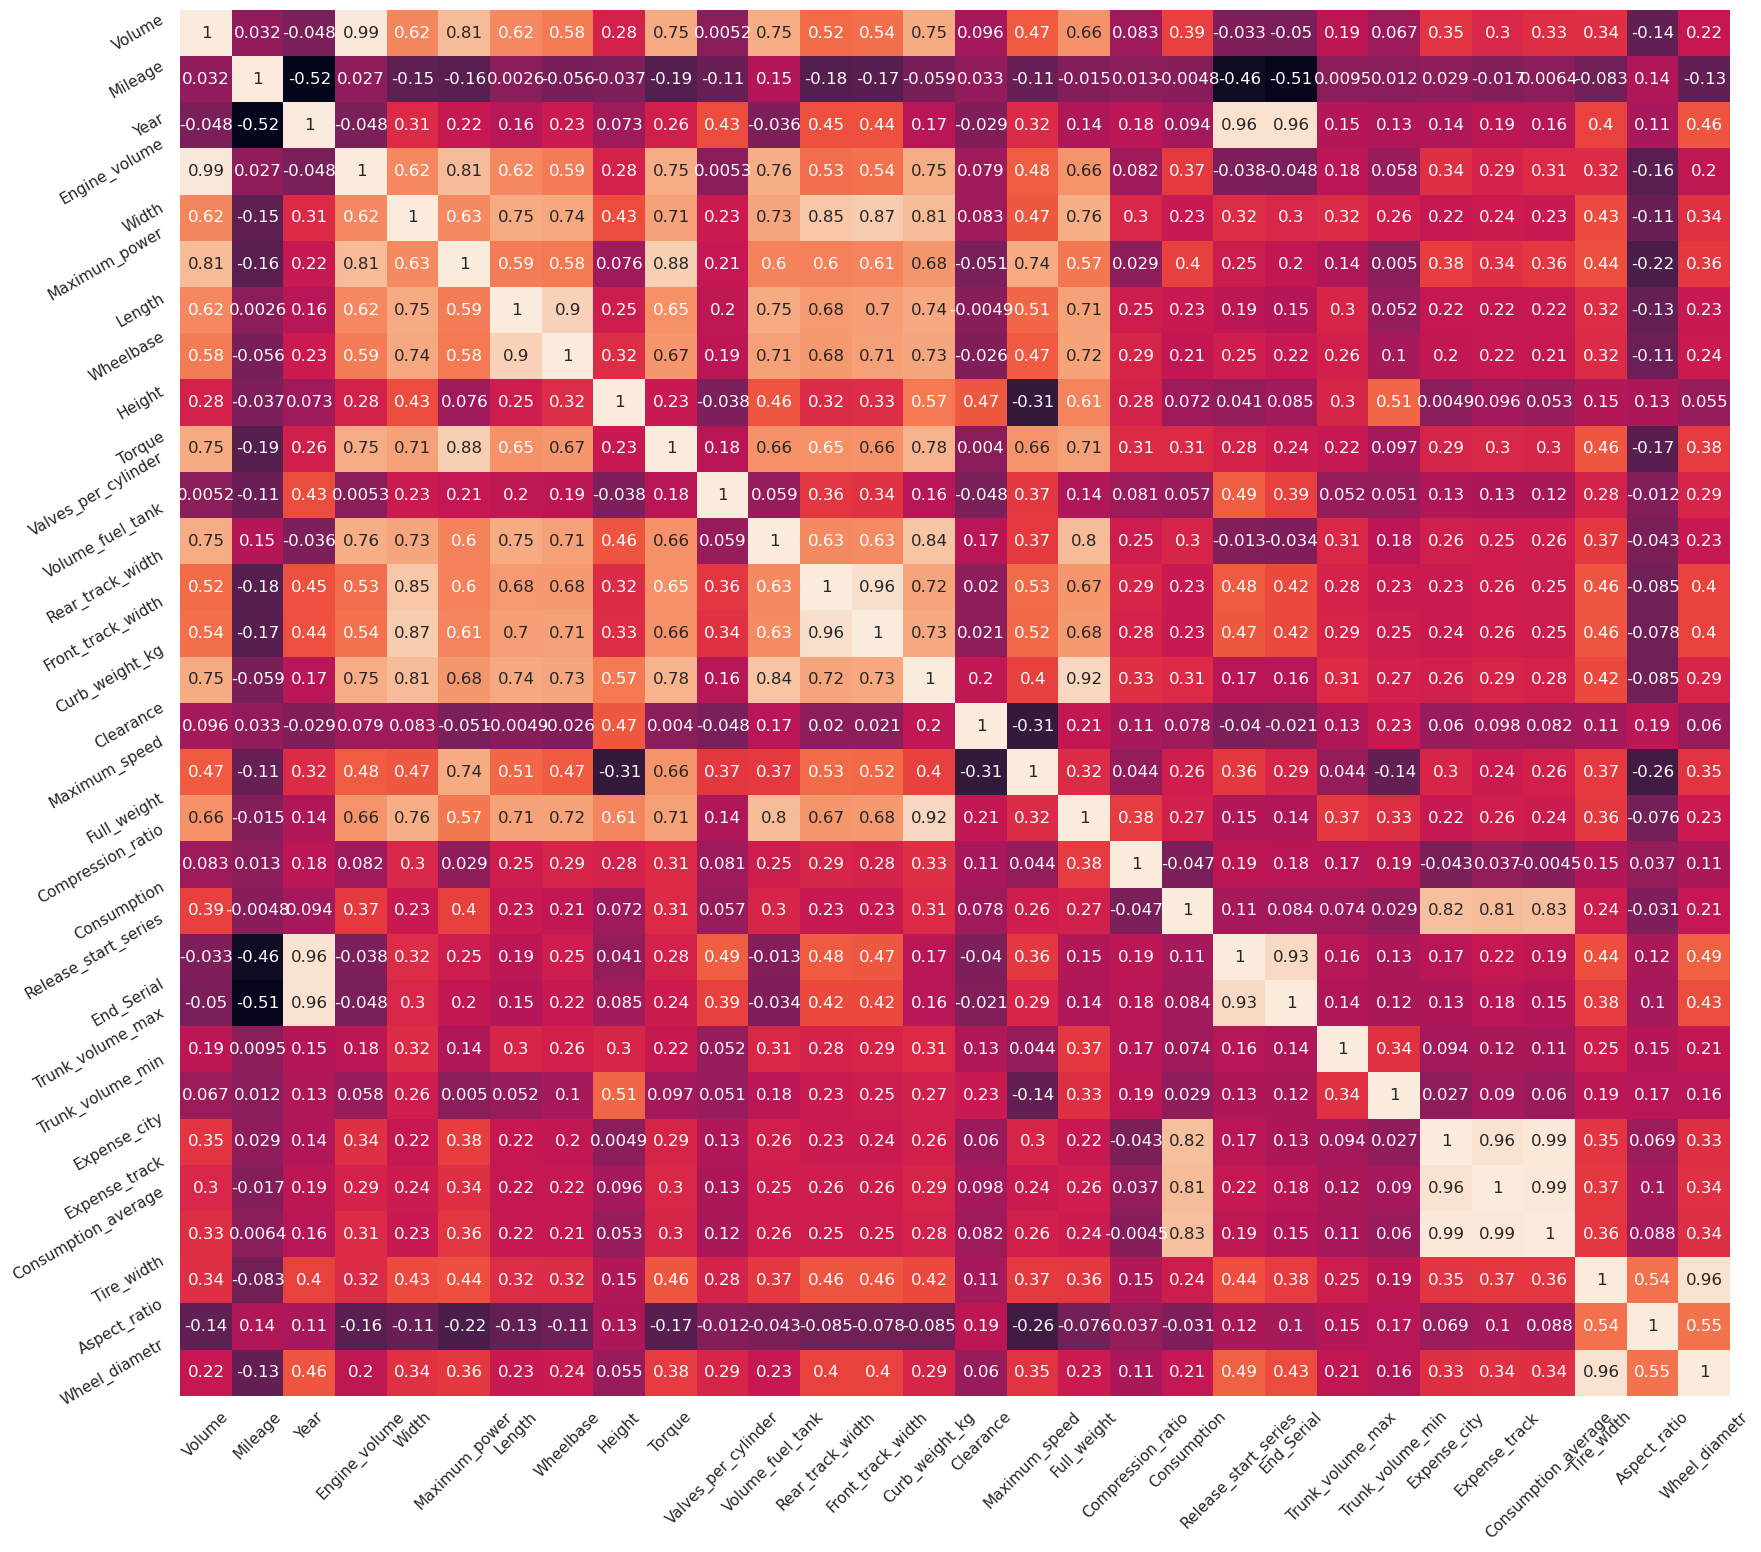

In [385]:
fig, ax = plt.subplots(figsize=(20, 18))
ax = sns.heatmap(data = df[numeric_features].drop("Diameter_cylinder_and_stroke_piston", \
            axis=1).corr(), ax=ax, cbar=False, annot=True)
plt.tick_params(axis='y', which='major', rotation=30)
plt.tick_params(axis='x', which='major', rotation=45)

### На матрице видны следующие мультикорреляционные зависимости:
+ **Год выпуска, год релиза серии и год конца выпуска (Year, Release_start_series, End_Serial)**
+ **Расход, средний расход, расход на треке и расход по городу (Consumption, Consumption_average, Expense_track, Expense_city)**
+ **Ширина передней и задней колеи с шириной автомобиля (Rear_track_width, Front_track_width, Width)**
+ **Полный вес и Снаряжённая масса (Full_weight, Curb_weight_kg)**
+ **Ширина шины и диаметр обода колеса (Tire_width, "Wheel_diametr")

## Посмотрим на фактор инфляции дисперсии.

In [393]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(df[numeric_features])  
vif = pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(vif)

const                                  163689.965148
Volume                                     61.430039
Mileage                                     1.780440
Year                                       24.968462
Engine_volume                              65.115905
Width                                       6.392673
Diameter_cylinder_and_stroke_piston         1.150956
Maximum_power                              12.711666
Length                                      7.548141
Wheelbase                                   6.619263
Height                                      4.548678
Torque                                     10.347943
Valves_per_cylinder                         1.585507
Volume_fuel_tank                            5.824781
Rear_track_width                           13.440027
Front_track_width                          14.637030
Curb_weight_kg                             12.268394
Clearance                                   1.505495
Maximum_speed                               5.

### С учётом всех замечаний выше удалим часть призноков и посмотрим ещё раз на vif.

In [394]:
X.drop(["Front_track_width", "Rear_track_width", "Length", "Expense_track", "Consumption",
       "Consumption_average", "Full_weight", "Volume", "End_Serial", "Release_start_series", \
        "Maximum_speed", "Wheel_diametr"], axis=1, inplace=True)

In [395]:
vif = pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(vif)

const                                  134927.315542
Mileage                                     1.710652
Year                                        2.441021
Engine_volume                               5.696228
Width                                       4.039420
Diameter_cylinder_and_stroke_piston         1.107990
Maximum_power                              11.219565
Wheelbase                                   3.020304
Height                                      2.997995
Torque                                      9.307493
Valves_per_cylinder                         1.414548
Volume_fuel_tank                            5.393808
Curb_weight_kg                              8.316177
Clearance                                   1.441711
Compression_ratio                           1.742761
Trunk_volume_max                            1.277734
Trunk_volume_min                            1.546024
Expense_city                                1.308214
Tire_width                                  3.

### Видим, что мультиколлинеарность стала гораздо ниже.

# 11. Исследование зависимости в данных с помощью дисперсионного анализа.

In [127]:
from scipy.stats import f_oneway

## Однофакторный дисперсионный анализ.

### Проверим гипотезу о том, что средняя цена на автомобиль одинакова для автомобилей с разным количеством дверей. 

In [129]:
doors5 = df.loc[df.Doors == 5, "Price"]
doors4 = df.loc[df.Doors == 4, "Price"]
doors3 = df.loc[df.Doors == 3, "Price"]
doors2 = df.loc[df.Doors == 2, "Price"]
f_oneway(doors2, doors3, doors4, doors5)

F_onewayResult(statistic=164.95565498873862, pvalue=8.740044422138077e-106)

In [125]:
%%R
summary(aov(df$Doors ~ df$Price))

               Df Sum Sq Mean Sq F value   Pr(>F)    
df$Price        1     26  25.914   39.54 3.27e-10 ***
Residuals   22700  14876   0.655                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Эта гипотезы отверглась,  так как у спорткаров количество дверей меньше, а цена их выше.

### Среднии цены на автомобиль с рестайлингом и без одинаковы:

In [120]:
rest0 = df.loc[df.Restyling == 0, "Price"]
rest1 = df.loc[df.Restyling == 1, "Price"]
f_oneway(rest0, rest1)

F_onewayResult(statistic=2.648045178192716, pvalue=0.10369119782547663)

In [126]:
%%R
summary(aov(df$Restyling ~ df$Price))

               Df Sum Sq Mean Sq F value Pr(>F)
df$Price        1      1  0.5940   2.648  0.104
Residuals   22700   5092  0.2243               


## Двухфакторный диспрессионный анализ.

In [137]:
%%R
A <- lm(df$Price ~ df$Doors*df$Restyling)
summary(A)
anova(A)

Analysis of Variance Table

Response: df$Price
                         Df     Sum Sq    Mean Sq F value    Pr(>F)    
df$Doors                  1 2.4552e+14 2.4552e+14 39.5788 3.208e-10 ***
df$Restyling              1 2.0444e+13 2.0444e+13  3.2957   0.06947 .  
df$Doors:df$Restyling     1 1.1695e+14 1.1695e+14 18.8525 1.418e-05 ***
Residuals             22698 1.4080e+17 6.2033e+12                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# 12. Линейная регрессия

In [633]:
numeric_features = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].drop(['Price',\
        'Speed_to_100', 'Cylinders', 'Transmissions', "Seats", "Doors", "Restyling"]).index.values
categorical_features = df.dtypes[(df.dtypes == 'object') | (df.dtypes.index.isin(['Cylinders',\
    'Transmissions', "Seats", "Doors", "Restyling"]))].drop(['mark', 'Country', 'Color',\
    'Generation', 'Model']).index.values

### Предобработка признаков

In [544]:
#df.groupby("mark", as_index=False).size().sort_values("size", ascending=False)[:15]

In [545]:
#df[["mark", "Price"]].groupby("mark", as_index=False).median().sort_values("Price", ascending=False)[:20]

In [546]:
#df.mark.value_counts()

In [547]:
numeric_features.shape

(28,)

In [548]:
categorical_features.shape

(19,)

In [549]:
df.shape

(22702, 54)

In [634]:
numeric_features

array(['Volume', 'Mileage', 'Year', 'Engine_volume', 'Width',
       'Diameter_cylinder_and_stroke_piston', 'Maximum_power', 'Length',
       'Wheelbase', 'Height', 'Torque', 'Valves_per_cylinder',
       'Volume_fuel_tank', 'Rear_track_width', 'Front_track_width',
       'Curb_weight_kg', 'Clearance', 'Maximum_speed', 'Full_weight',
       'Compression_ratio', 'Consumption', 'Release_start_series',
       'End_Serial', 'Trunk_volume_max', 'Trunk_volume_min',
       'Expense_city', 'Expense_track', 'Consumption_average'],
      dtype=object)

In [659]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df.Price, test_size=0.3, random_state=10)

In [636]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))
print("Test r2 = %.4f" % r2_score(y_test, y_pred))
print("Train r2 = %.4f" % r2_score(y_train, y_train_pred))

Test MSE = 4319226881573.5532
Train MSE = 3022679122172.3745
Test r2 = 0.4043
Train r2 = 0.4768


In [637]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -1820232.5419
	-1453321.1579
	-1399722.5765
	-1382567.8996
	-1412704.3013
	-1526659.5542
	-1150910.6768
	-3549479.5153
	-1129381.8058
	-1335161.7340
Mean CV MSE = 1616014.1763


In [638]:
def show_weights(features, weights, means, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=3)
    sorted_weights = sorted(zip(weights, features, means, scales), reverse=True)
    weights, features, means, scales = zip(*sorted_weights)
    features = list(features)
    
    sns.barplot(y=features, x=list(weights), ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=list(means), ax=axs[1])
    axs[1].set_xlabel("Mean")
    sns.barplot(y=features, x=list(scales), ax=axs[2])
    axs[2].set_xlabel("Scale")
    plt.tight_layout()

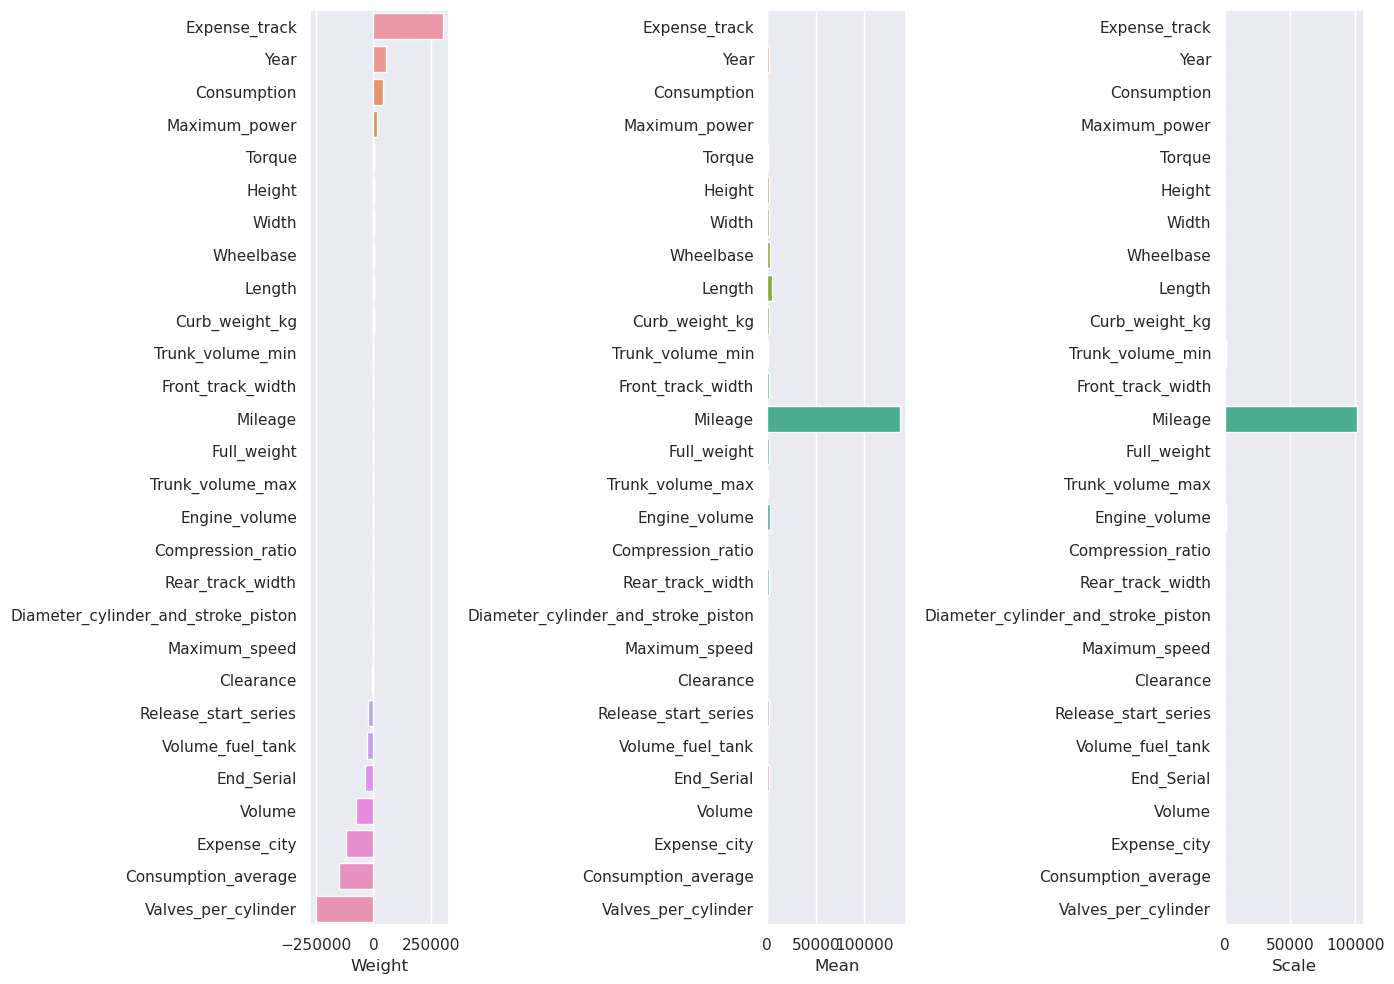

In [639]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].mean(), X_train[numeric_features].std())

In [640]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred))
print("Test r2 = %.4f" % r2_score(y_test, y_pred))
print("Train r2 = %.4f" % r2_score(y_train, y_train_pred))

Test RMSE = 4319308439326.4131
Train RMSE = 3022680286966.5254
Test r2 = 0.4043
Train r2 = 0.4768


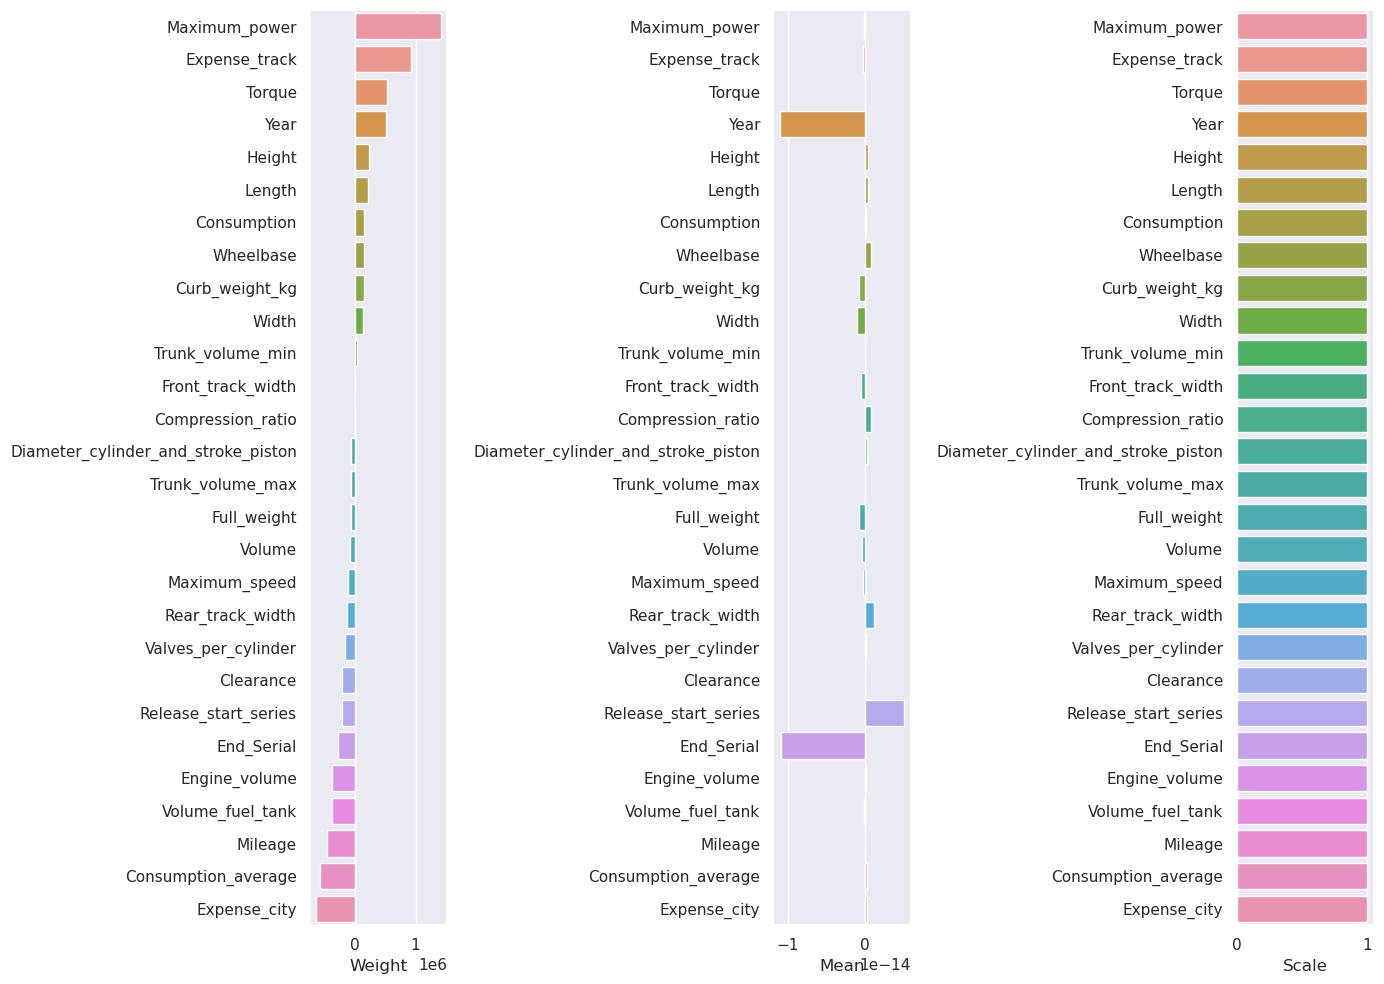

In [641]:
means = pd.Series(data=X_train_scaled.mean(axis=0), index=numeric_features)
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, means, scales)

Best alpha = 4.0949


Text(0, 0.5, 'CV score')

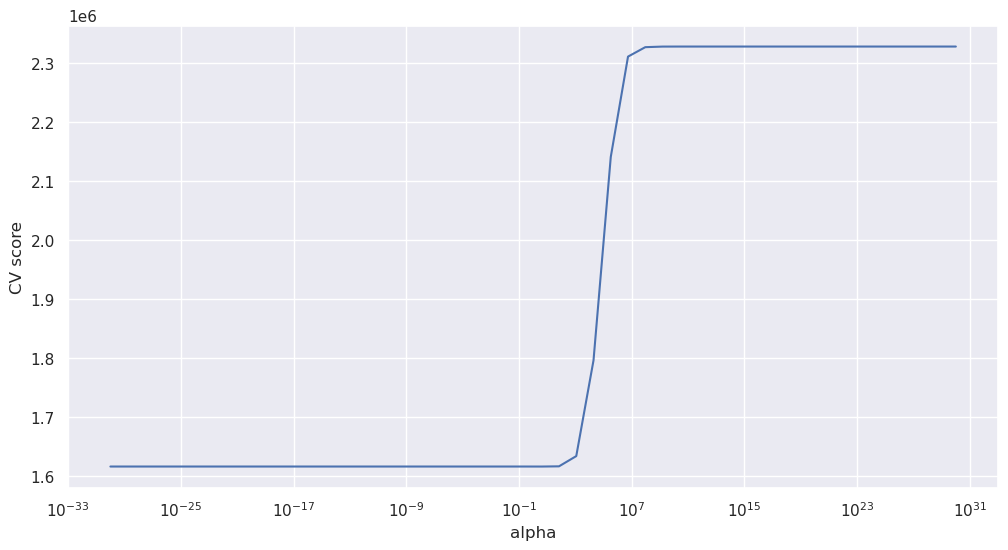

In [650]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-30, 30, 50)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [648]:
indexes = [np.where(numeric_features == i)[0][0] for i in ["Front_track_width", "Rear_track_width", "Length",\
        "Expense_track", "Consumption", "Consumption_average", "Full_weight", "Volume", "End_Serial",\
        "Release_start_series", "Maximum_speed"]]

In [651]:
new_numeric_features = np.delete(numeric_features, indexes)

In [656]:
X_train_scaled = scaler.fit_transform(X_train[new_numeric_features])
X_test_scaled = scaler.transform(X_test[new_numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred))
print("Test r2 = %.4f" % r2_score(y_test, y_pred))
print("Train r2 = %.4f" % r2_score(y_train, y_train_pred))

Test RMSE = 4373422379088.3311
Train RMSE = 3082721700645.3667
Test r2 = 0.3968
Train r2 = 0.4664


In [660]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test r2 = %.4f" % r2_score(y_test, y_pred))

ValueError: A given column is not a column of the dataframe